# Import Statements

In [1]:
from __future__ import print_function

import larq as lq
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
import tensorflow as tf

np.random.seed(1337)

2024-12-08 20:58:55.032758: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 20:58:55.034484: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 20:58:55.063576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 20:58:55.063898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 20:58:55.678916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Read Dataset

In [2]:
train_df = pd.read_csv('datasets/UNSW_NB15/UNSW_NB15_training-set.csv', delimiter=',')
test_df = pd.read_csv('datasets/UNSW_NB15/UNSW_NB15_testing-set.csv', delimiter=',')

In [3]:
data_df = pd.concat([train_df,test_df])

In [4]:
data_df = data_df.drop(['id'], axis=1)
cols = ['proto', 'service', 'state']
for col in cols:
    data_df[col] =  data_df[col].astype('category')
    data_df[col] =  data_df[col].cat.codes

# Feature selection and Model Training (All Feature)

In [5]:
selected_columns = [
    'dur',
    'proto',
    'sbytes', 'dbytes',
    'sttl', 'dttl',
    'sload', 'dload',
    'spkts', 'dpkts',
    'smean', 'dmean',
    'sinpkt', 'dinpkt',
    'tcprtt', 'synack', 'ackdat',
    'ct_src_ltm', 'ct_dst_ltm',
    'ct_dst_src_ltm',

    'attack_cat'
]

In [6]:
data_df = data_df[selected_columns]
X = data_df[data_df.columns[:20]].values
Y = data_df[data_df.columns[20]].values

In [7]:
data_df.columns

Index(['dur', 'proto', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload',
       'spkts', 'dpkts', 'smean', 'dmean', 'sinpkt', 'dinpkt', 'tcprtt',
       'synack', 'ackdat', 'ct_src_ltm', 'ct_dst_ltm', 'ct_dst_src_ltm',
       'attack_cat'],
      dtype='object')

In [8]:
Xint = X.astype("int")

In [9]:
size_in_bits = {
    'dur': 8,
    'proto': 8,
    'sbytes': 16, 'dbytes': 16,
    'sttl': 8, 'dttl': 8,
    'sload': 24, 'dload': 24,
    'spkts': 16, 'dpkts': 16,
    'smean': 16, 'dmean': 16,
    'sinpkt': 16, 'dinpkt': 16,
    'tcprtt': 8, 'synack': 8, 'ackdat': 8,
    'ct_src_ltm': 8, 'ct_dst_ltm': 8,
    'ct_dst_src_ltm': 8,
}

sum(size_in_bits.values())

256

In [10]:
Xbin = np.zeros( (Xint.shape[0], sum(size_in_bits.values())) )
for i, feature_row in enumerate(Xint):
    # the index at which the next binary value should be written
    write_ptr = 0
    for j, column_val in enumerate(feature_row):
        # Transforming in KB sbytes, dbytes, sload, dload
        if j in [2,3,6,7]:
            column_val = int(column_val/1000) 
        # Setting to maximum any value above the max given the number of b
        if (column_val > 2**size_in_bits[selected_columns[j]] - 1):
            column_val = 2**size_in_bits[selected_columns[j]] - 1
        tmp = list(bin(column_val)[2:])
        tmp = [int(x) for x in tmp]
        # zero padding to the left
        tmp = [0]*(size_in_bits[selected_columns[j]] - len(tmp)) + tmp
        for k, bin_val in enumerate(tmp):
            Xbin[i,write_ptr] = bin_val
            write_ptr += 1

In [11]:
# DT/RF dataset
Y__2_classes = Y.copy()
Y__2_classes[Y == 'Normal'] = 0
Y__2_classes[Y != 'Normal'] = 1
Y__2_classes = Y__2_classes.astype('int')

# BNN dataset
Xbin[Xbin == 0] = -1
X_bin = Xbin

Y_cat__2_classes = np_utils.to_categorical(Y__2_classes)

In [12]:
def plot_confusion_matrix_wo_clf(y_true, y_pred, class_names, normalize='true'):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    if normalize == 'true':
        disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    else:
        disp.plot(cmap=plt.cm.Blues, ax=ax)
    
    plt.show()

In [13]:
def metrics_binary_dataset(clf, X_test, y_test, y_pred, y_score, is_bnn=False):
    
    if is_bnn:
        # Make y_test 1D
        y_test = np.argmax(y_test, axis=1)
        
    plot_confusion_matrix_wo_clf(y_test, y_pred, ['0','1'])
   
    a = accuracy_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    tpr = r
    fpr = fp / (fp+tn)
    fnr = fn / (fn+tp)
    tnr = tn / (tn+fp)
    
    y_score = to_categorical(y_pred)
    fpr_, tpr_, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr_, tpr_)

    return a, p, r, tpr, fpr, fnr, f1, roc_auc

In [14]:
def build_bnn_model(neurons, 
                    input_shape, 
                    last_act="softmax", 
                    learning_rate=0.0001, 
                    loss='squared_hinge'):
    
    kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

    model = tf.keras.models.Sequential()
    model.add(lq.layers.QuantDense(neurons[0], use_bias=False,
                                   input_quantizer="ste_sign",
                                   kernel_quantizer="ste_sign",
                                   kernel_constraint="weight_clip",
                                   input_shape=(input_shape,) ) )
    model.add(tf.keras.layers.BatchNormalization(scale=False, momentum=0.9))
    model.add(lq.layers.QuantDense(neurons[1], use_bias=False, **kwargs))
    model.add(tf.keras.layers.BatchNormalization(scale=False, momentum=0.9))
    model.add(lq.layers.QuantDense(neurons[2], use_bias=False, activation=last_act, **kwargs))

    # lq.models.summary(model)
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    
    return model

In [15]:
depths_range = [3, 6, 9]
estimators_range = [5]

bnn_models = [
    [32, 16, 2],
    [64, 32, 2],
    [128, 64, 2]
]

In [16]:
batch_size = 256
num_folds = 5
train_epochs = 15

DT: depth=3, fold_idx=0


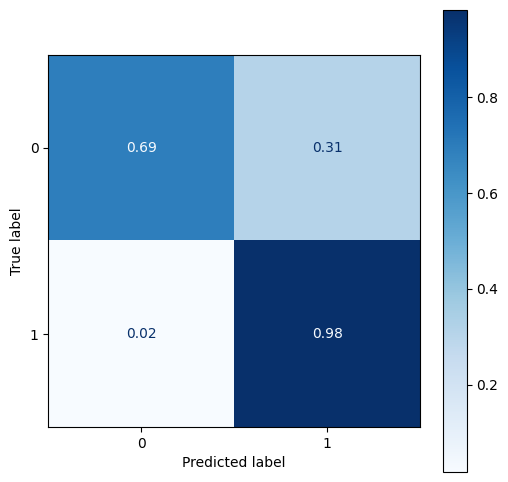

----------------------------------------
DT: depth=3, fold_idx=1


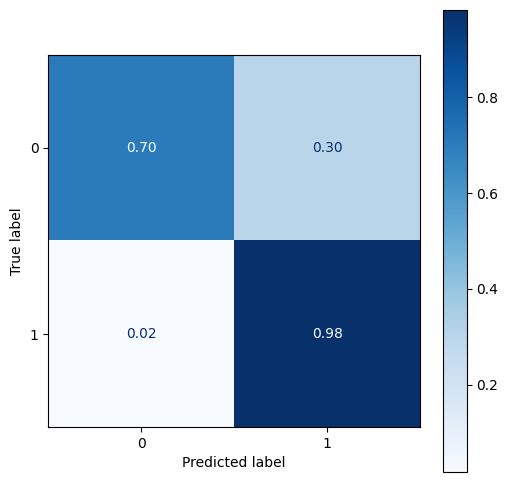

----------------------------------------
DT: depth=3, fold_idx=2


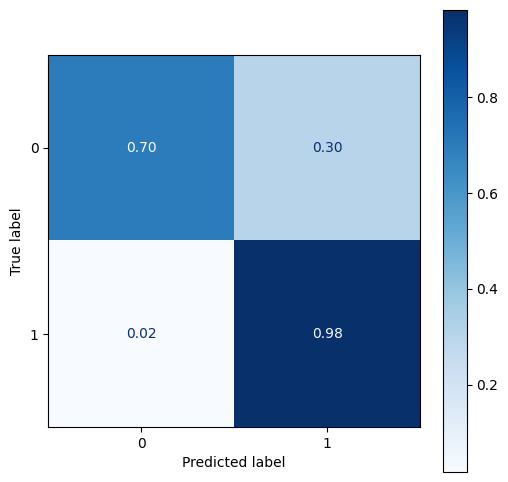

----------------------------------------
DT: depth=3, fold_idx=3


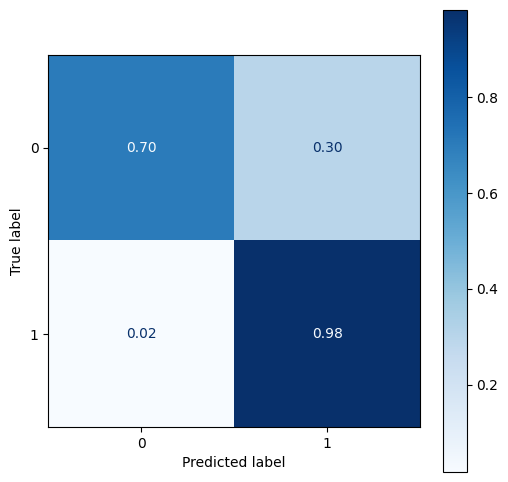

----------------------------------------
DT: depth=3, fold_idx=4


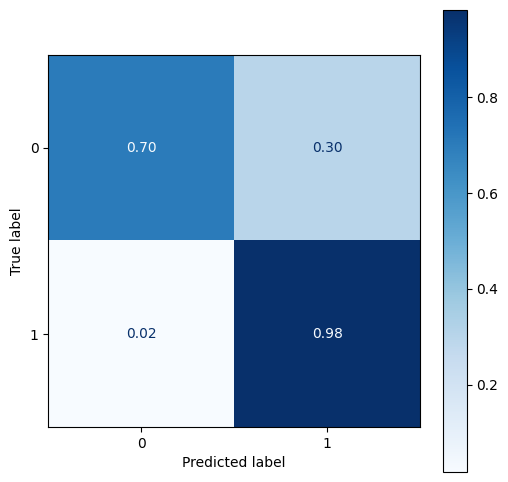

----------------------------------------
DT: depth=6, fold_idx=0


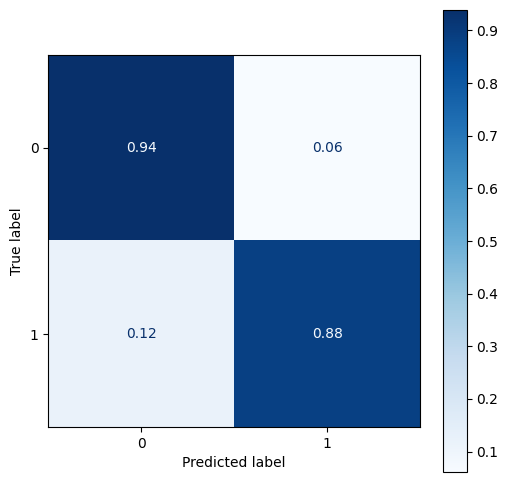

----------------------------------------
DT: depth=6, fold_idx=1


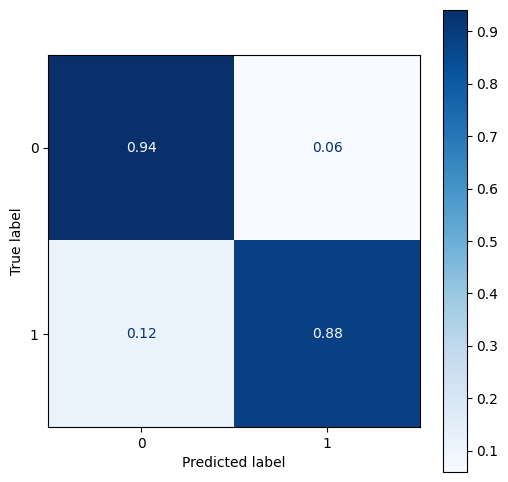

----------------------------------------
DT: depth=6, fold_idx=2


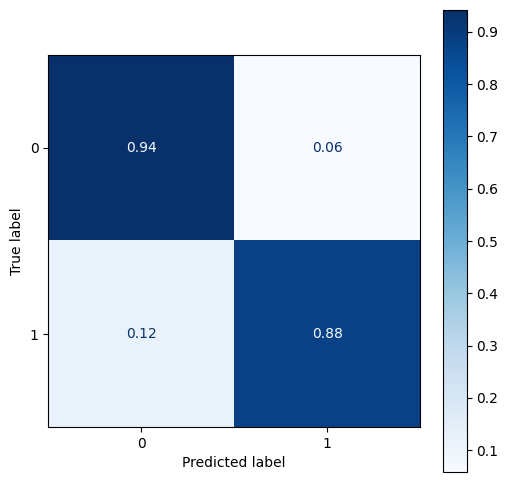

----------------------------------------
DT: depth=6, fold_idx=3


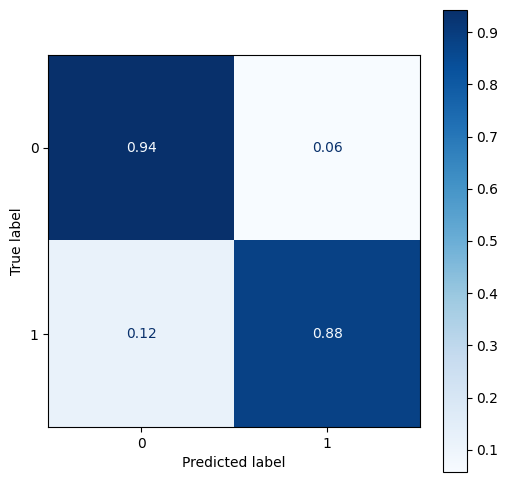

----------------------------------------
DT: depth=6, fold_idx=4


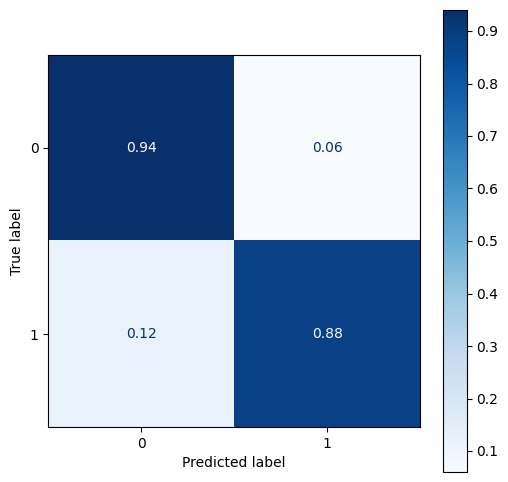

----------------------------------------
DT: depth=9, fold_idx=0


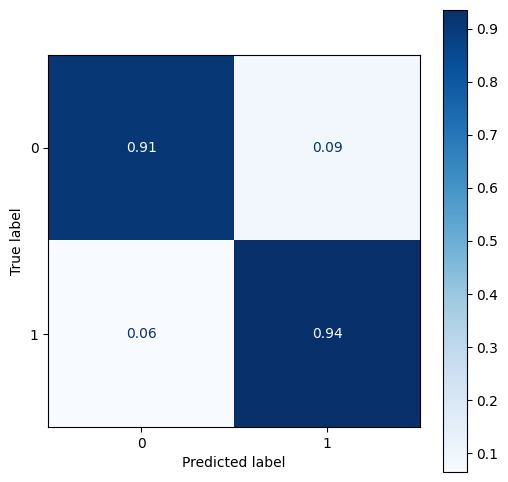

----------------------------------------
DT: depth=9, fold_idx=1


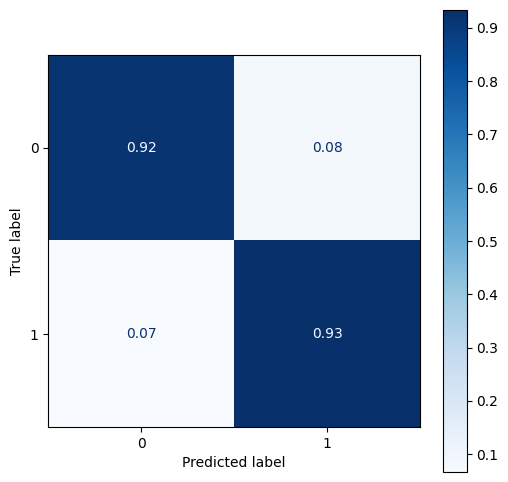

----------------------------------------
DT: depth=9, fold_idx=2


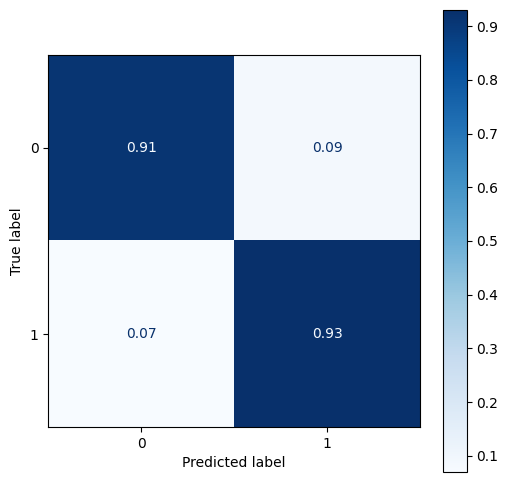

----------------------------------------
DT: depth=9, fold_idx=3


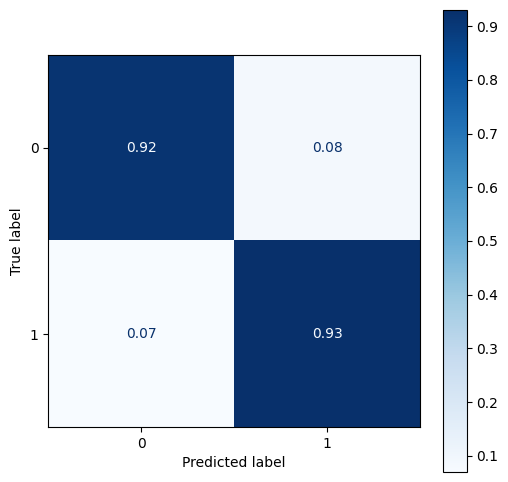

----------------------------------------
DT: depth=9, fold_idx=4


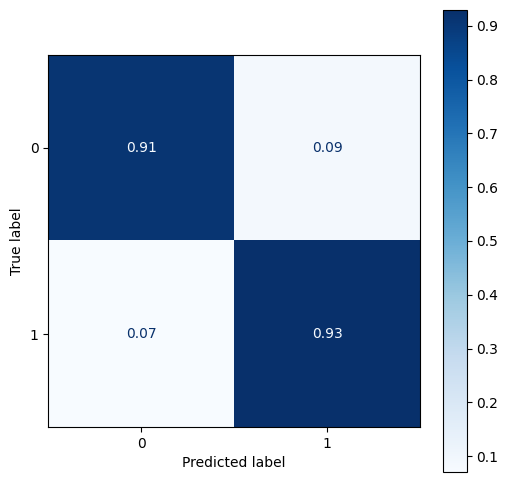

----------------------------------------
RF: depth=3, estimators=5, fold_idx=0


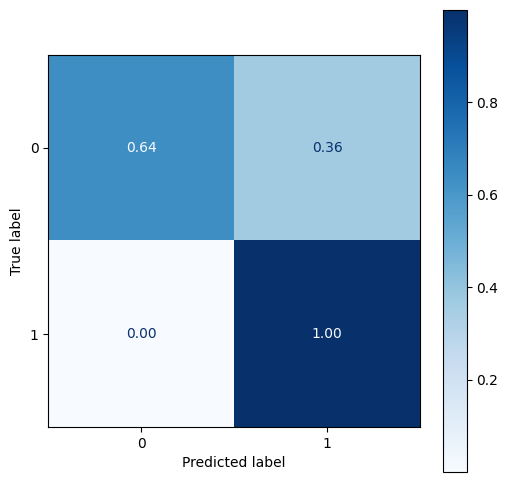

----------------------------------------
RF: depth=3, estimators=5, fold_idx=1


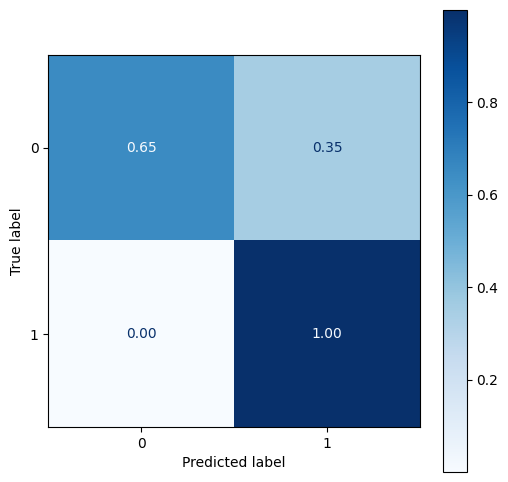

----------------------------------------
RF: depth=3, estimators=5, fold_idx=2


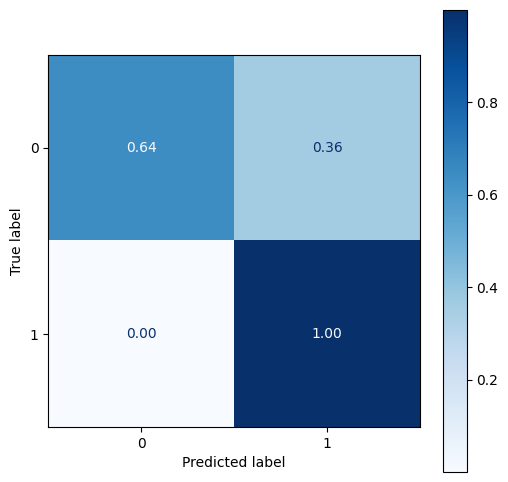

----------------------------------------
RF: depth=3, estimators=5, fold_idx=3


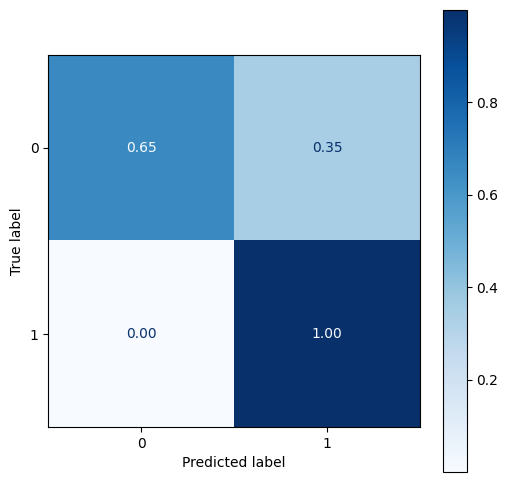

----------------------------------------
RF: depth=3, estimators=5, fold_idx=4


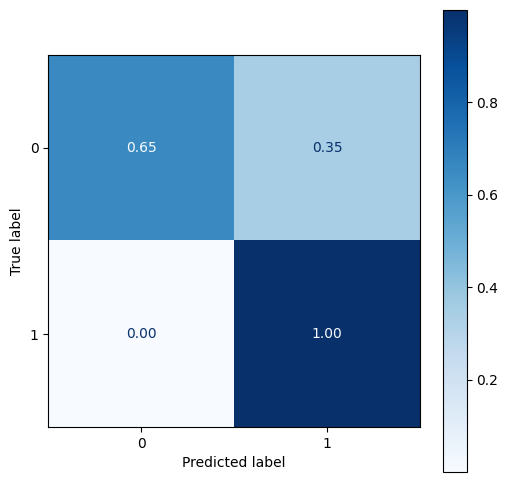

----------------------------------------
RF: depth=6, estimators=5, fold_idx=0


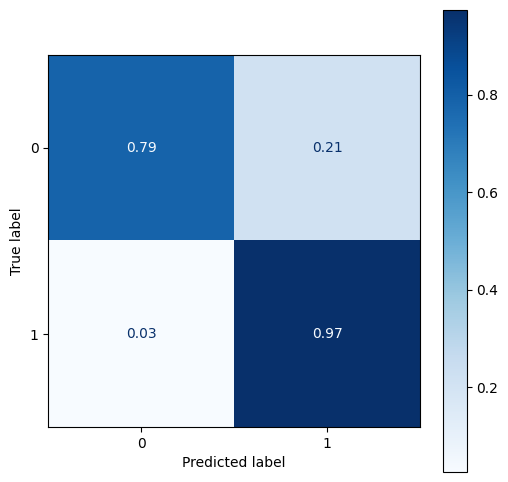

----------------------------------------
RF: depth=6, estimators=5, fold_idx=1


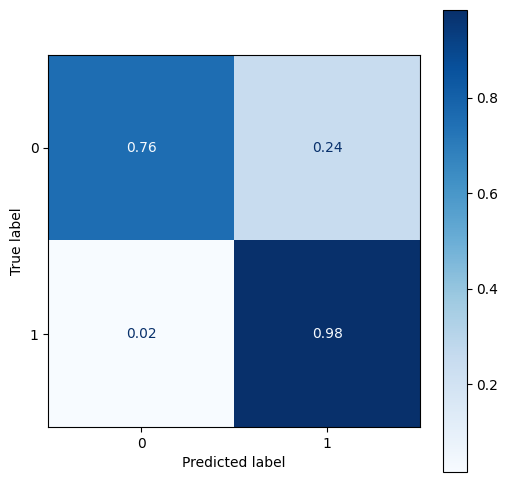

----------------------------------------
RF: depth=6, estimators=5, fold_idx=2


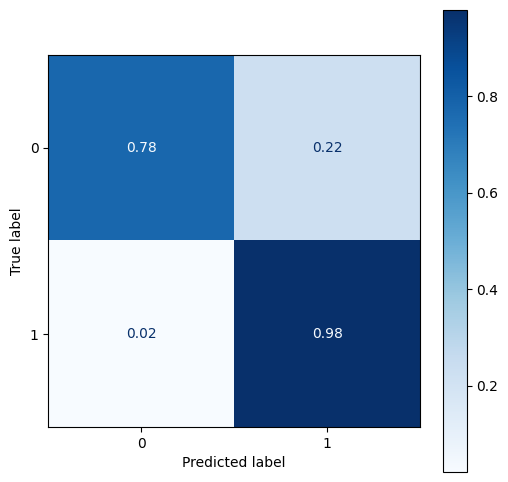

----------------------------------------
RF: depth=6, estimators=5, fold_idx=3


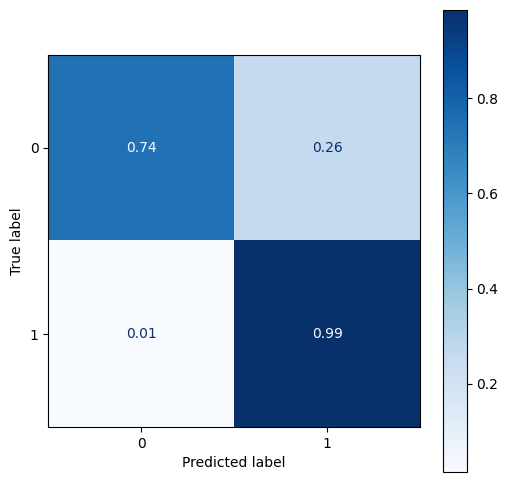

----------------------------------------
RF: depth=6, estimators=5, fold_idx=4


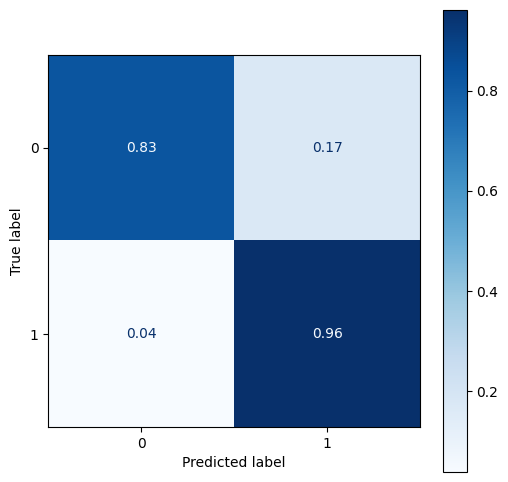

----------------------------------------
RF: depth=9, estimators=5, fold_idx=0


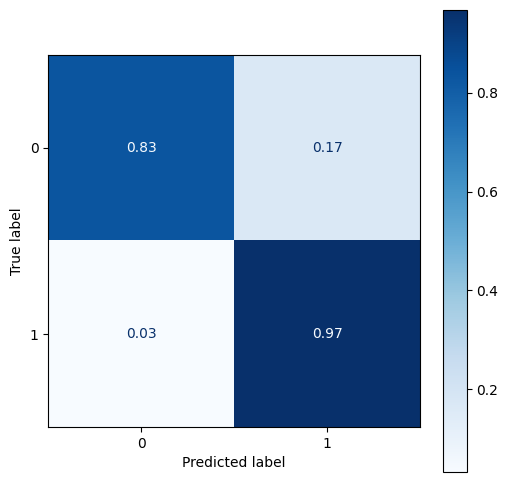

----------------------------------------
RF: depth=9, estimators=5, fold_idx=1


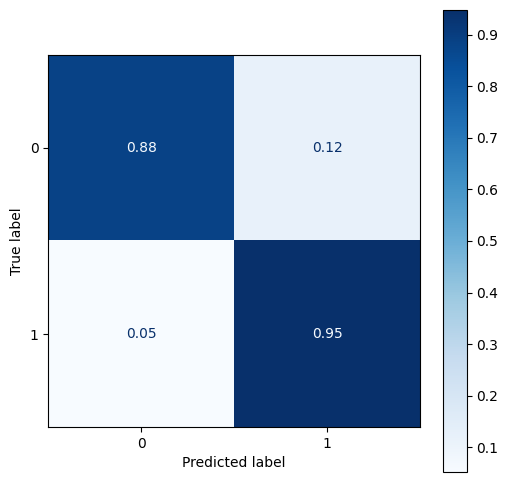

----------------------------------------
RF: depth=9, estimators=5, fold_idx=2


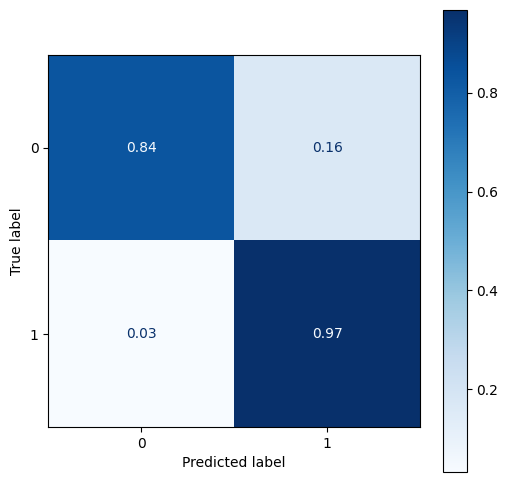

----------------------------------------
RF: depth=9, estimators=5, fold_idx=3


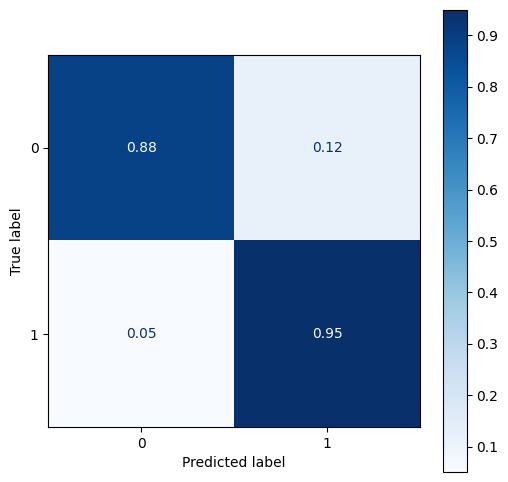

----------------------------------------
RF: depth=9, estimators=5, fold_idx=4


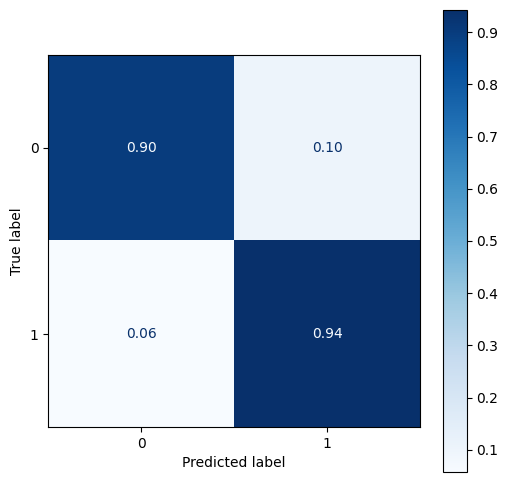

----------------------------------------
BNN [32, 16, 2] , fold_idx=0
Loading models/bnn__sec_StratifiedShuffleSplit__32_16_2__fold0.h5
806/806 [==============================] - 0s 420us/step


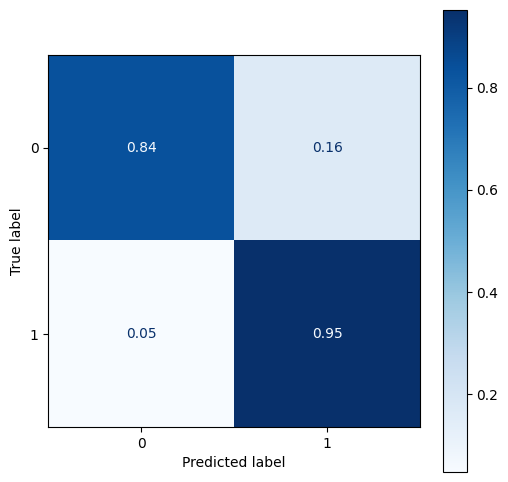

----------------------------------------
BNN [32, 16, 2] , fold_idx=1
Loading models/bnn__sec_StratifiedShuffleSplit__32_16_2__fold1.h5
806/806 [==============================] - 0s 439us/step


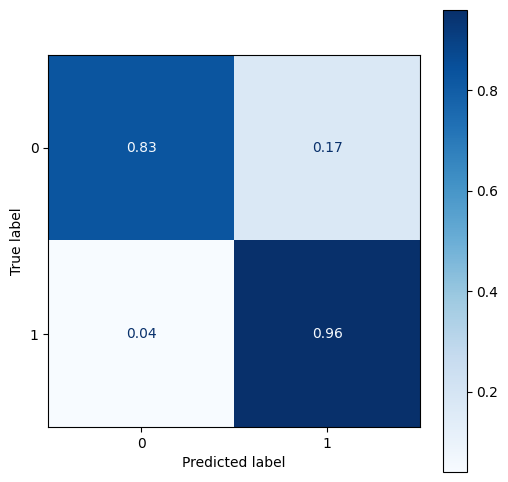

----------------------------------------
BNN [32, 16, 2] , fold_idx=2
Loading models/bnn__sec_StratifiedShuffleSplit__32_16_2__fold2.h5
806/806 [==============================] - 0s 440us/step


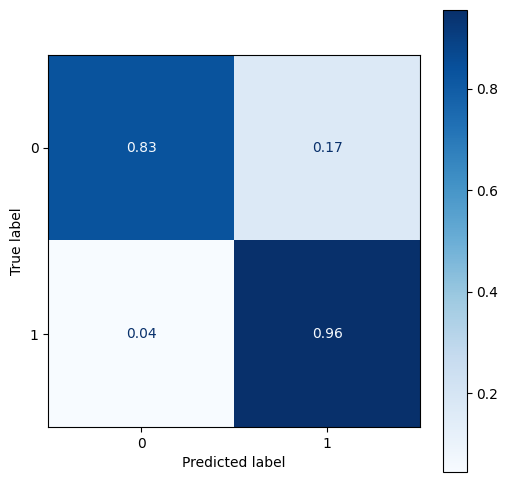

----------------------------------------
BNN [32, 16, 2] , fold_idx=3
Loading models/bnn__sec_StratifiedShuffleSplit__32_16_2__fold3.h5
806/806 [==============================] - 0s 440us/step


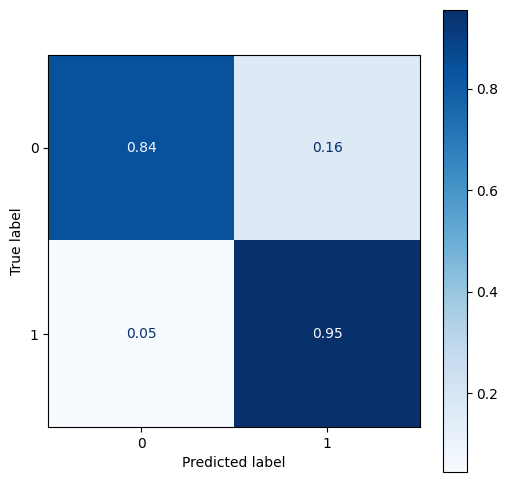

----------------------------------------
BNN [32, 16, 2] , fold_idx=4
Loading models/bnn__sec_StratifiedShuffleSplit__32_16_2__fold4.h5
806/806 [==============================] - 0s 408us/step


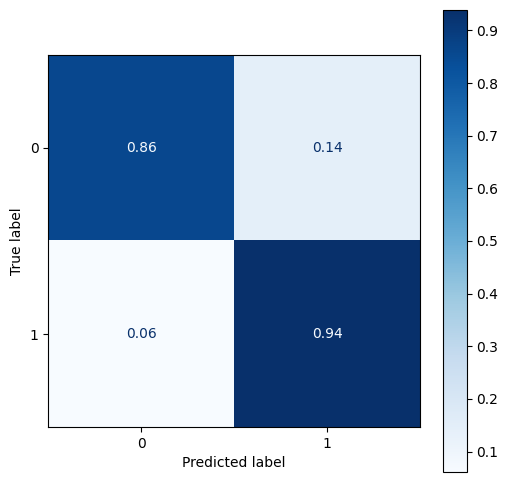

----------------------------------------
BNN [64, 32, 2] , fold_idx=0
Loading models/bnn__sec_StratifiedShuffleSplit__64_32_2__fold0.h5
806/806 [==============================] - 0s 372us/step


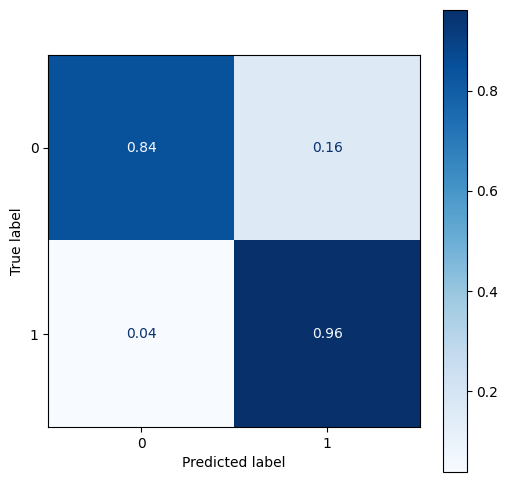

----------------------------------------
BNN [64, 32, 2] , fold_idx=1
Loading models/bnn__sec_StratifiedShuffleSplit__64_32_2__fold1.h5
806/806 [==============================] - 0s 396us/step


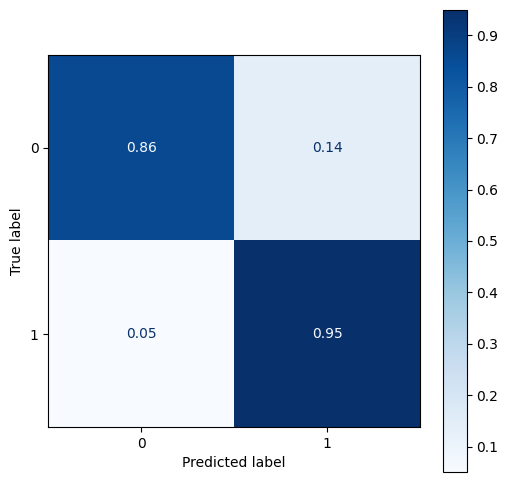

----------------------------------------
BNN [64, 32, 2] , fold_idx=2
Loading models/bnn__sec_StratifiedShuffleSplit__64_32_2__fold2.h5
806/806 [==============================] - 0s 438us/step


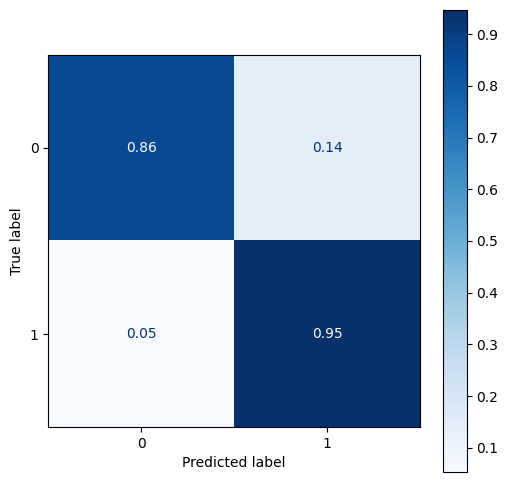

----------------------------------------
BNN [64, 32, 2] , fold_idx=3
Loading models/bnn__sec_StratifiedShuffleSplit__64_32_2__fold3.h5
806/806 [==============================] - 0s 467us/step


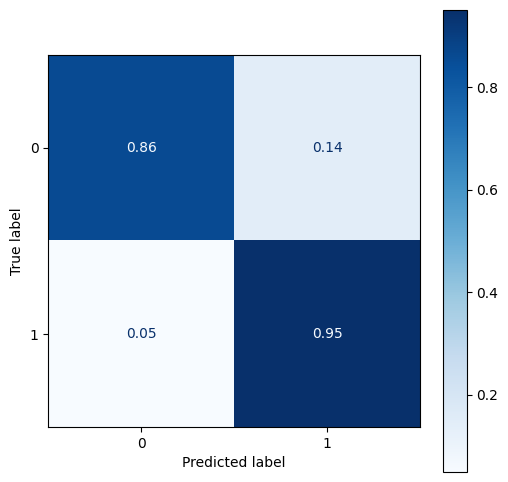

----------------------------------------
BNN [64, 32, 2] , fold_idx=4
Loading models/bnn__sec_StratifiedShuffleSplit__64_32_2__fold4.h5
806/806 [==============================] - 0s 458us/step


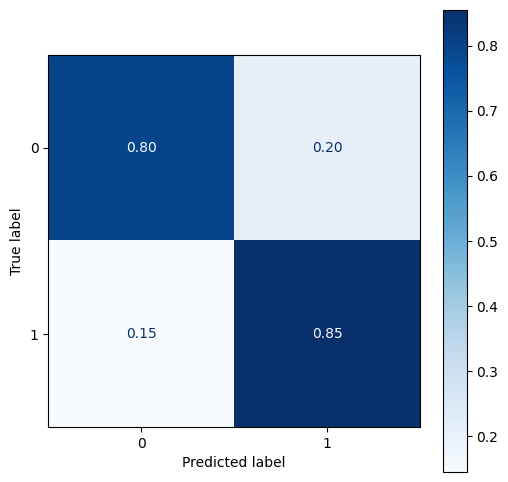

----------------------------------------
BNN [128, 64, 2] , fold_idx=0
Epoch 1/15
904/906 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.8124
Epoch 1: val_accuracy improved from -inf to 0.87391, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 3s 2ms/step - loss: 0.8558 - accuracy: 0.8126 - val_loss: 0.7459 - val_accuracy: 0.8739
Epoch 2/15
 78/906 [=>............................] - ETA: 1s - loss: 0.7318 - accuracy: 0.8776

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


882/906 [============================>.] - ETA: 0s - loss: 0.7185 - accuracy: 0.8856
Epoch 2: val_accuracy improved from 0.87391 to 0.89405, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.7183 - accuracy: 0.8856 - val_loss: 0.7056 - val_accuracy: 0.8941
Epoch 3/15
902/906 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.8991
Epoch 3: val_accuracy improved from 0.89405 to 0.90317, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.6954 - accuracy: 0.8991 - val_loss: 0.6903 - val_accuracy: 0.9032
Epoch 4/15
896/906 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.9045
Epoch 4: val_accuracy improved from 0.90317 to 0.90671, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.685

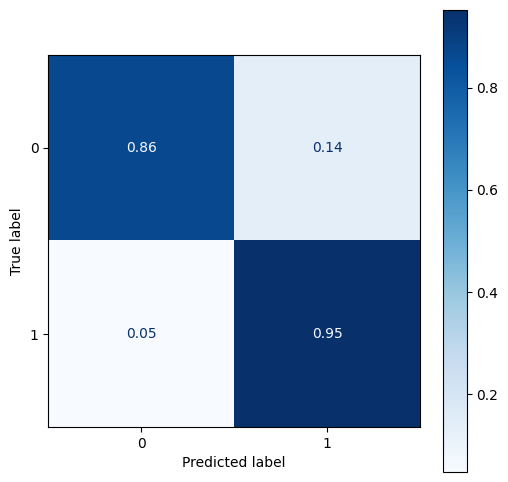

----------------------------------------
BNN [128, 64, 2] , fold_idx=1
Loading models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold1.h5
806/806 [==============================] - 0s 495us/step


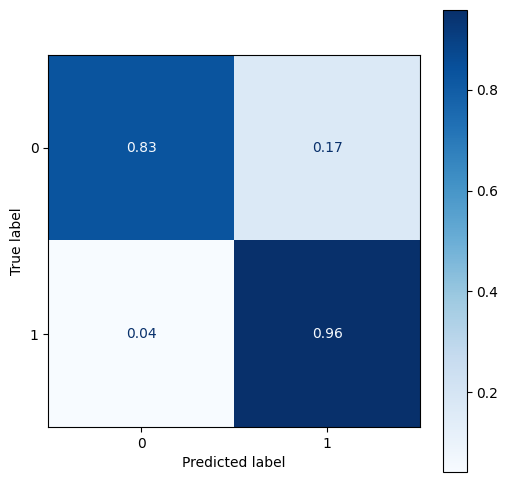

----------------------------------------
BNN [128, 64, 2] , fold_idx=2
Epoch 1/15
892/906 [============================>.] - ETA: 0s - loss: 0.8782 - accuracy: 0.7938
Epoch 1: val_accuracy improved from -inf to 0.86735, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.8762 - accuracy: 0.7950 - val_loss: 0.7603 - val_accuracy: 0.8674
Epoch 2/15
 79/906 [=>............................] - ETA: 1s - loss: 0.7525 - accuracy: 0.8709

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


903/906 [============================>.] - ETA: 0s - loss: 0.7291 - accuracy: 0.8827
Epoch 2: val_accuracy improved from 0.86735 to 0.89134, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.7290 - accuracy: 0.8828 - val_loss: 0.7129 - val_accuracy: 0.8913
Epoch 3/15
894/906 [============================>.] - ETA: 0s - loss: 0.7006 - accuracy: 0.8974
Epoch 3: val_accuracy improved from 0.89134 to 0.89984, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.7006 - accuracy: 0.8974 - val_loss: 0.6963 - val_accuracy: 0.8998
Epoch 4/15
885/906 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.9030
Epoch 4: val_accuracy improved from 0.89984 to 0.90434, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.688

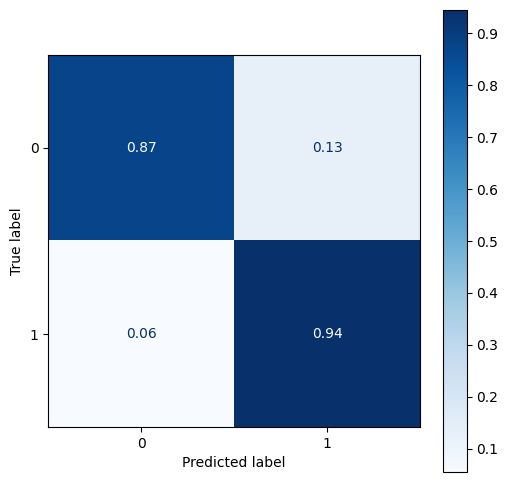

----------------------------------------
BNN [128, 64, 2] , fold_idx=3
Loading models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold3.h5
806/806 [==============================] - 0s 497us/step


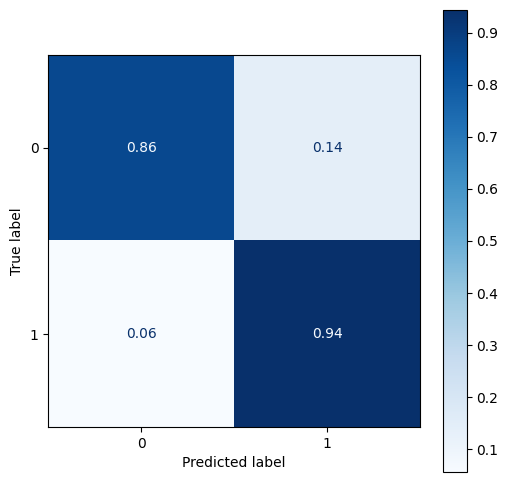

----------------------------------------
BNN [128, 64, 2] , fold_idx=4
Epoch 1/15
900/906 [============================>.] - ETA: 0s - loss: 0.8381 - accuracy: 0.8207
Epoch 1: val_accuracy improved from -inf to 0.88365, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.8375 - accuracy: 0.8210 - val_loss: 0.7278 - val_accuracy: 0.8837
Epoch 2/15
 81/906 [=>............................] - ETA: 1s - loss: 0.7323 - accuracy: 0.8766

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


888/906 [============================>.] - ETA: 0s - loss: 0.7150 - accuracy: 0.8886
Epoch 2: val_accuracy improved from 0.88365 to 0.88971, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.7149 - accuracy: 0.8886 - val_loss: 0.7071 - val_accuracy: 0.8897
Epoch 3/15
904/906 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.8982
Epoch 3: val_accuracy improved from 0.88971 to 0.89902, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.6978 - accuracy: 0.8982 - val_loss: 0.6918 - val_accuracy: 0.8990
Epoch 4/15
890/906 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.9028
Epoch 4: val_accuracy improved from 0.89902 to 0.90236, saving model to models/bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 2s 2ms/step - loss: 0.689

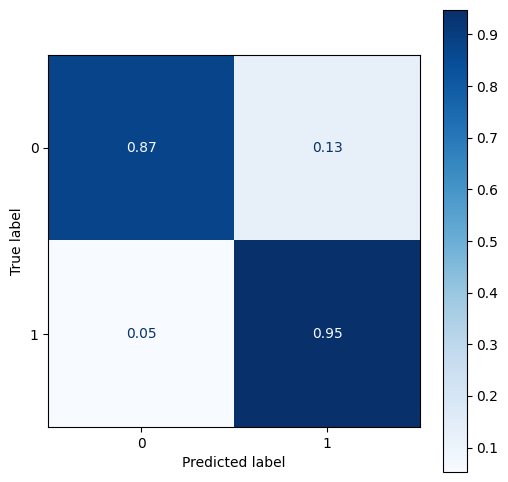

----------------------------------------


In [17]:
accuracy_store_sec = {}
precision_store_sec = {}
recall_store_sec = {}
tpr_store_sec = {}
fpr_store_sec = {}
fnr_store_sec = {}
f1_store_sec = {}
roc_auc_store_sec = {}

########################################

skf = StratifiedShuffleSplit(n_splits=num_folds, random_state=0)

for depth in depths_range:    
    label = 'dt__depth_%d' % (depth)
    accuracy_store_sec[label] = np.zeros(num_folds)
    precision_store_sec[label] = np.zeros(num_folds)
    recall_store_sec[label] = np.zeros(num_folds)
    tpr_store_sec[label] = np.zeros(num_folds)
    fpr_store_sec[label] = np.zeros(num_folds)
    fnr_store_sec[label] = np.zeros(num_folds)
    f1_store_sec[label] = np.zeros(num_folds)
    roc_auc_store_sec[label] = np.zeros(num_folds)
    
    fold_idx = 0
    for train_index, test_index in skf.split(X, Y):
        print('DT: depth=%d, fold_idx=%d' % (depth, fold_idx))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y__2_classes[train_index], Y__2_classes[test_index]
                        
        dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
        dt = dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        y_score = dt.predict_proba(X_test)

        a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(dt, X_test, y_test, y_pred, y_score)
        accuracy_store_sec[label][fold_idx] = a
        precision_store_sec[label][fold_idx] = p
        recall_store_sec[label][fold_idx] = r
        tpr_store_sec[label][fold_idx] = tpr
        fpr_store_sec[label][fold_idx] = fpr
        fnr_store_sec[label][fold_idx] = fnr
        f1_store_sec[label][fold_idx] = f1
        roc_auc_store_sec[label][fold_idx] = roc_auc

        fold_idx += 1

        print('-'*40)
    
    print('='*80)

########################################################################################

for depth in depths_range:
    for estimators in estimators_range:
        label = 'rf__depth_%d__estimators_%d' % (depth, estimators)
        accuracy_store_sec[label] = np.zeros(num_folds)
        precision_store_sec[label] = np.zeros(num_folds)
        recall_store_sec[label] = np.zeros(num_folds)
        tpr_store_sec[label] = np.zeros(num_folds)
        fpr_store_sec[label] = np.zeros(num_folds)
        fnr_store_sec[label] = np.zeros(num_folds)
        f1_store_sec[label] = np.zeros(num_folds)
        roc_auc_store_sec[label] = np.zeros(num_folds)

        fold_idx = 0
        for train_index, test_index in skf.split(X, Y):
            print('RF: depth=%d, estimators=%d, fold_idx=%d' % (depth, estimators, fold_idx))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y__2_classes[train_index], Y__2_classes[test_index]

            rf = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=estimators, random_state=0)
            rf = rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_score = rf.predict_proba(X_test)

            a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(rf, X_test, y_test, y_pred, y_score)
            accuracy_store_sec[label][fold_idx] = a
            precision_store_sec[label][fold_idx] = p
            recall_store_sec[label][fold_idx] = r
            tpr_store_sec[label][fold_idx] = tpr
            fpr_store_sec[label][fold_idx] = fpr
            fnr_store_sec[label][fold_idx] = fnr
            f1_store_sec[label][fold_idx] = f1
            roc_auc_store_sec[label][fold_idx] = roc_auc
        
            fold_idx += 1

            print('-'*40)
            
        print('='*40)

    print('='*80)

########################################################################################

for neurons in bnn_models:
    label = 'bnn__%s' % ('_'.join(map(str, neurons)))
    accuracy_store_sec[label] = np.zeros(num_folds)
    precision_store_sec[label] = np.zeros(num_folds)
    recall_store_sec[label] = np.zeros(num_folds)
    tpr_store_sec[label] = np.zeros(num_folds)
    fpr_store_sec[label] = np.zeros(num_folds)
    fnr_store_sec[label] = np.zeros(num_folds)
    f1_store_sec[label] = np.zeros(num_folds)
    roc_auc_store_sec[label] = np.zeros(num_folds)
    
    fold_idx = 0
    for train_index, test_index in skf.split(X, Y):
        print('BNN', neurons ,', fold_idx=%d' % (fold_idx))
        X_train, X_test = X_bin[train_index], X_bin[test_index]
        y_train, y_test = Y_cat__2_classes[train_index], Y_cat__2_classes[test_index]
                        
        model = build_bnn_model(neurons, X_bin.shape[1])   
        fname = 'bnn__sec_StratifiedShuffleSplit__%s__fold%d.h5' % ('_'.join(map(str, neurons)), fold_idx)
        
        model_checkpoint_callback = ModelCheckpoint(
            filepath='models/' + fname,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1)
        
        if not os.path.isfile('models/' + fname):
            train_history = model.fit(X_train, y_train, 
                              batch_size=batch_size, 
                              epochs=train_epochs,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[model_checkpoint_callback])
                    
            # Reload best weights
            model.load_weights('models/' + fname)
        else:
            # Reload stored weights
            print('Loading models/' + fname)
            model.load_weights('models/' + fname)

        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob,axis=1)
        y_score = y_prob[y_pred]
        
        a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(model, X_test, y_test, y_pred, y_score, is_bnn=True)
        accuracy_store_sec[label][fold_idx] = a
        precision_store_sec[label][fold_idx] = p
        recall_store_sec[label][fold_idx] = r
        tpr_store_sec[label][fold_idx] = tpr
        fpr_store_sec[label][fold_idx] = fpr
        fnr_store_sec[label][fold_idx] = fnr
        f1_store_sec[label][fold_idx] = f1
        roc_auc_store_sec[label][fold_idx] = roc_auc
        
        fold_idx += 1
        
        print('-'*40)
    
    print('='*80)

In [18]:
for store,metric in zip([accuracy_store_sec, precision_store_sec, recall_store_sec,
                         fnr_store_sec, fpr_store_sec, f1_store_sec, roc_auc_store_sec],
                        ['Accuracy', 'Precision', 'Recall', 'FNR', 'FPR', 'F1-score', 'ROC-AUC']):
    print('[%s]' % metric)
    for key in store:
        print('%s: %.1f ± %.1f' % (key, 100*store[key].mean(), 100*store[key].std()))
    print()

[Accuracy]
dt__depth_3: 88.0 ± 0.2
dt__depth_6: 90.3 ± 0.1
dt__depth_9: 92.5 ± 0.2
rf__depth_3__estimators_5: 87.3 ± 0.2
rf__depth_6__estimators_5: 90.5 ± 0.5
rf__depth_9__estimators_5: 92.3 ± 0.3
bnn__32_16_2: 91.1 ± 0.1
bnn__64_32_2: 90.0 ± 3.3
bnn__128_64_2: 91.7 ± 0.4

[Precision]
dt__depth_3: 85.3 ± 0.2
dt__depth_6: 96.3 ± 0.1
dt__depth_9: 95.0 ± 0.1
rf__depth_3__estimators_5: 83.4 ± 0.3
rf__depth_6__estimators_5: 88.6 ± 1.3
rf__depth_9__estimators_5: 92.7 ± 1.3
bnn__32_16_2: 91.3 ± 0.5
bnn__64_32_2: 91.2 ± 1.6
bnn__128_64_2: 92.3 ± 0.8

[Recall]
dt__depth_3: 98.2 ± 0.0
dt__depth_6: 88.2 ± 0.2
dt__depth_9: 93.2 ± 0.2
rf__depth_3__estimators_5: 99.9 ± 0.0
rf__depth_6__estimators_5: 97.7 ± 0.9
rf__depth_9__estimators_5: 95.5 ± 1.1
bnn__32_16_2: 95.2 ± 0.7
bnn__64_32_2: 93.3 ± 3.9
bnn__128_64_2: 94.9 ± 0.5

[FNR]
dt__depth_3: 1.8 ± 0.0
dt__depth_6: 11.8 ± 0.2
dt__depth_9: 6.8 ± 0.2
rf__depth_3__estimators_5: 0.1 ± 0.0
rf__depth_6__estimators_5: 2.3 ± 0.9
rf__depth_9__estimators_5: 4.

# Feature Selection and Model Training (Simple Feature Only)

In [19]:
selected_columns = [
    'proto',
    'sbytes', 'dbytes',
    'sttl', 'dttl',
    'spkts', 'dpkts',
    'tcprtt', 'synack', 'ackdat',

    'attack_cat'
]

In [20]:
data_df = data_df[selected_columns]
X = data_df[data_df.columns[:10]].values
Y = data_df[data_df.columns[10]].values
Xint = X.astype("int")
size_in_bits = {
    'proto': 8,
    'sbytes': 16, 'dbytes': 16,
    'sttl': 8, 'dttl': 8,
    'spkts': 16, 'dpkts': 16,
    'tcprtt': 8, 'synack': 8, 'ackdat': 8,
}

sum(size_in_bits.values())

112

In [21]:
Xbin = np.zeros( (Xint.shape[0], sum(size_in_bits.values())) )
for i, feature_row in enumerate(Xint):
    # the index at which the next binary value should be written
    write_ptr = 0
    for j, column_val in enumerate(feature_row):
        # Transforming in KB sbytes, dbytes, sload, dload
        if j in [1,2]:
            column_val = int(column_val/1000) 
        # Setting to maximum any value above the max given the number of b
        if (column_val > 2**size_in_bits[selected_columns[j]] - 1):
            column_val = 2**size_in_bits[selected_columns[j]] - 1
        tmp = list(bin(column_val)[2:])
        tmp = [int(x) for x in tmp]
        # zero padding to the left
        tmp = [0]*(size_in_bits[selected_columns[j]] - len(tmp)) + tmp
        for k, bin_val in enumerate(tmp):
            Xbin[i,write_ptr] = bin_val
            write_ptr += 1

In [22]:
# DT/RF dataset
Y__2_classes = Y.copy()
Y__2_classes[Y == 'Normal'] = 0
Y__2_classes[Y != 'Normal'] = 1
Y__2_classes = Y__2_classes.astype('int')

# BNN dataset
Xbin[Xbin == 0] = -1
X_bin = Xbin

Y_cat__2_classes = np_utils.to_categorical(Y__2_classes)

DT: depth=3, fold_idx=0


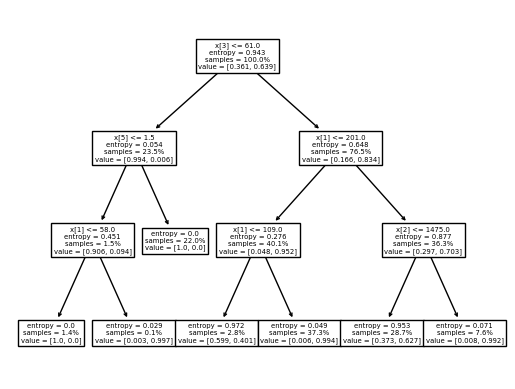

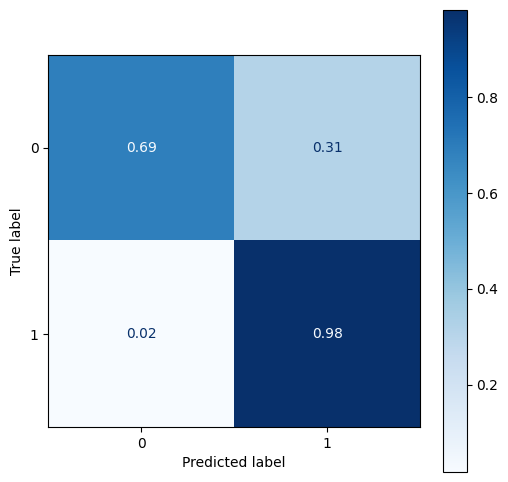

----------------------------------------
DT: depth=3, fold_idx=1


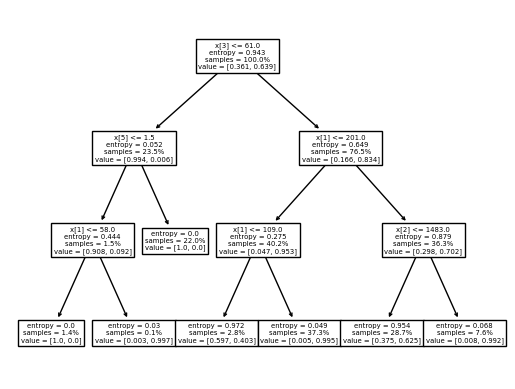

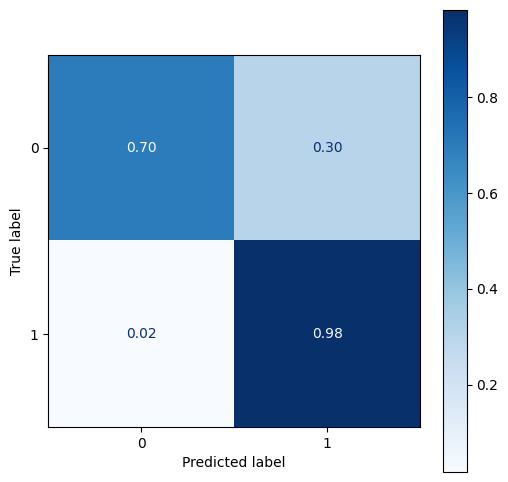

----------------------------------------
DT: depth=3, fold_idx=2


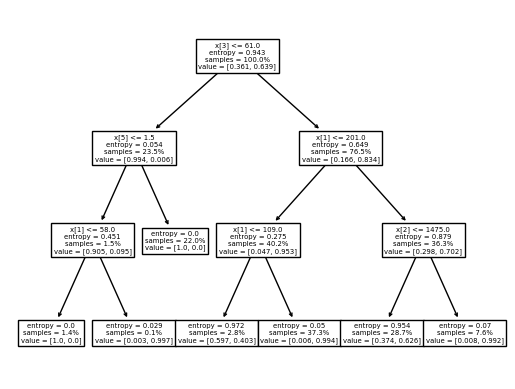

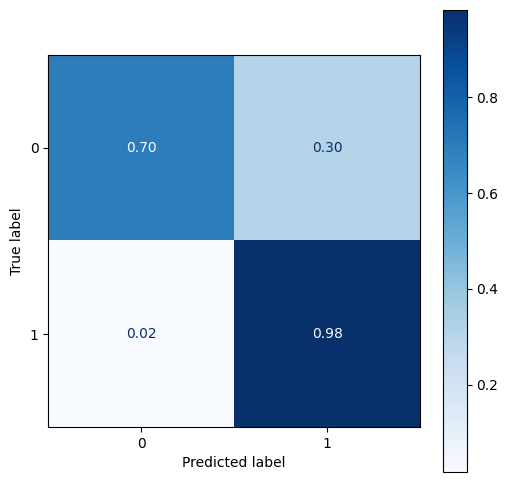

----------------------------------------
DT: depth=3, fold_idx=3


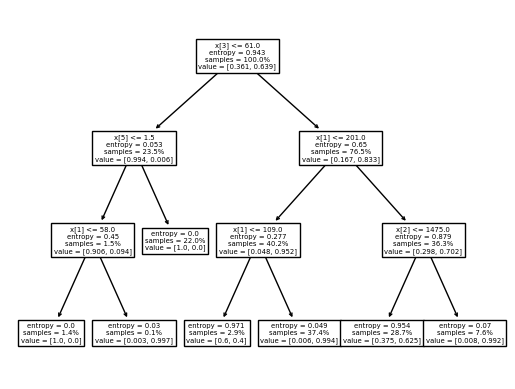

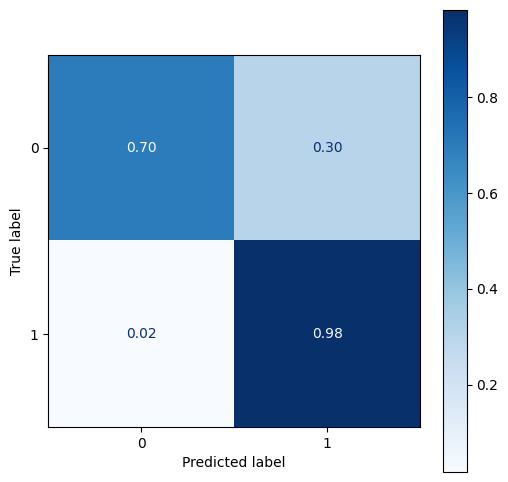

----------------------------------------
DT: depth=3, fold_idx=4


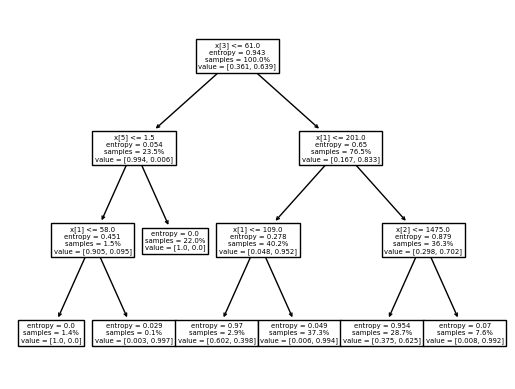

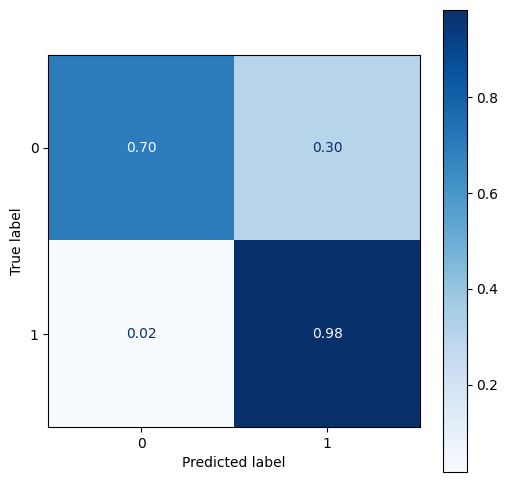

----------------------------------------
DT: depth=6, fold_idx=0


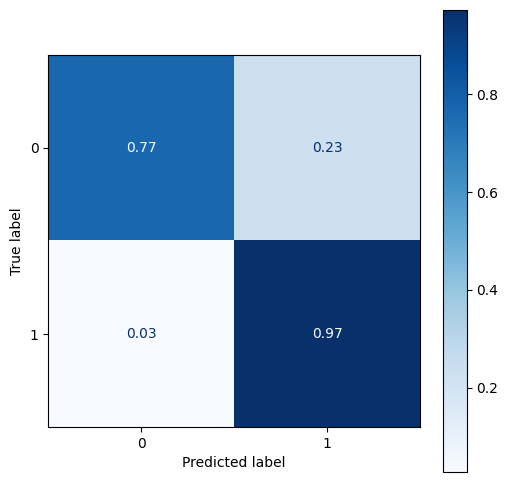

----------------------------------------
DT: depth=6, fold_idx=1


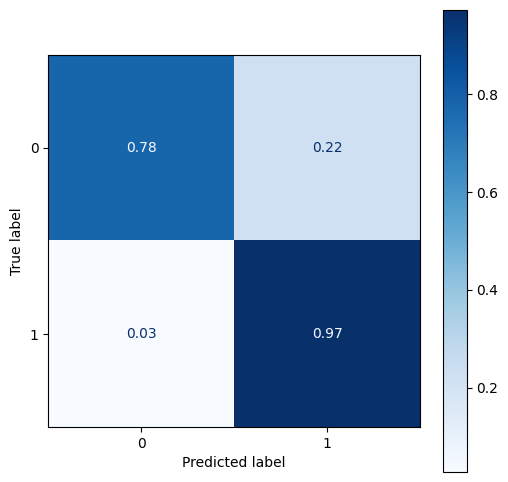

----------------------------------------
DT: depth=6, fold_idx=2


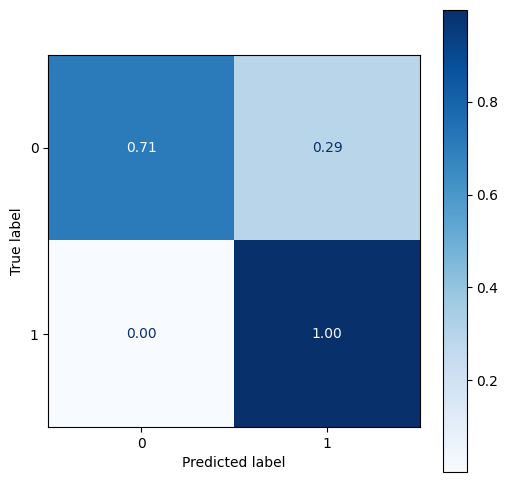

----------------------------------------
DT: depth=6, fold_idx=3


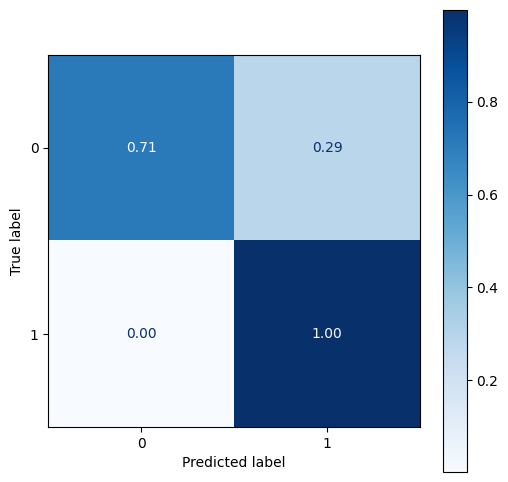

----------------------------------------
DT: depth=6, fold_idx=4


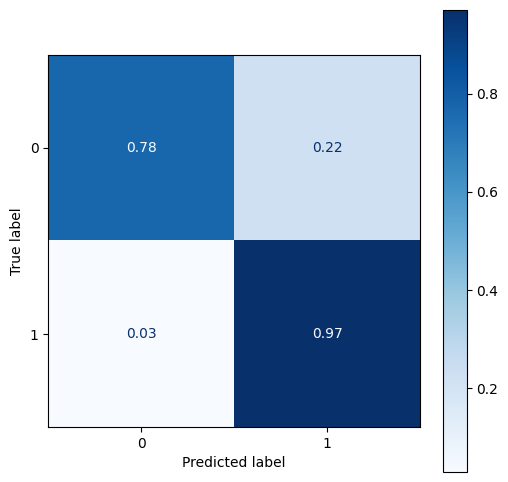

----------------------------------------
DT: depth=9, fold_idx=0


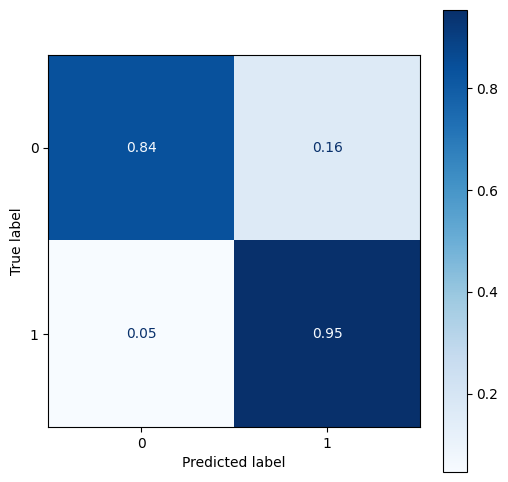

----------------------------------------
DT: depth=9, fold_idx=1


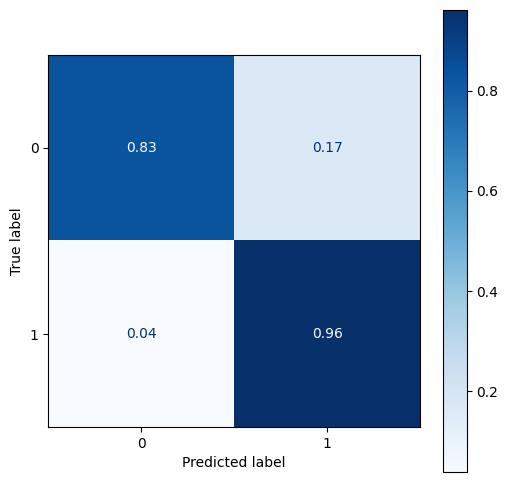

----------------------------------------
DT: depth=9, fold_idx=2


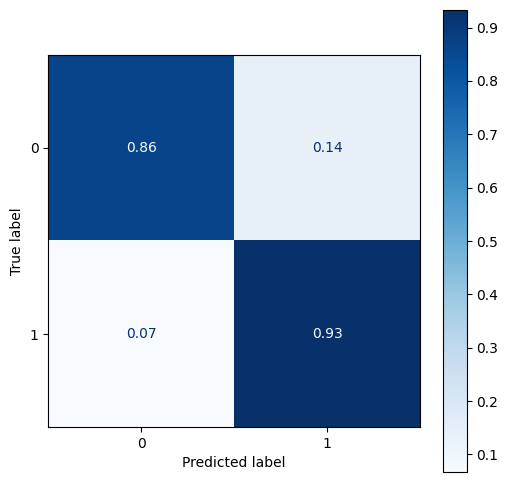

----------------------------------------
DT: depth=9, fold_idx=3


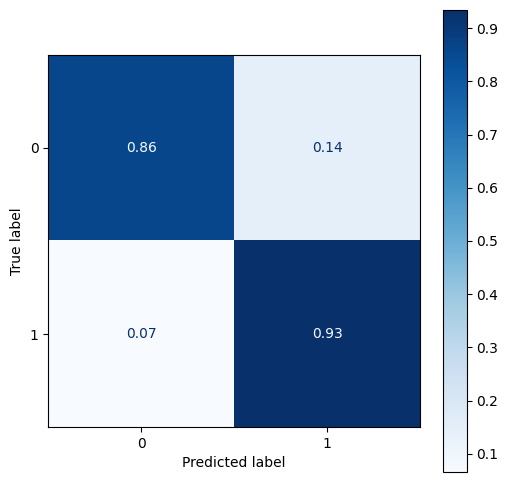

----------------------------------------
DT: depth=9, fold_idx=4


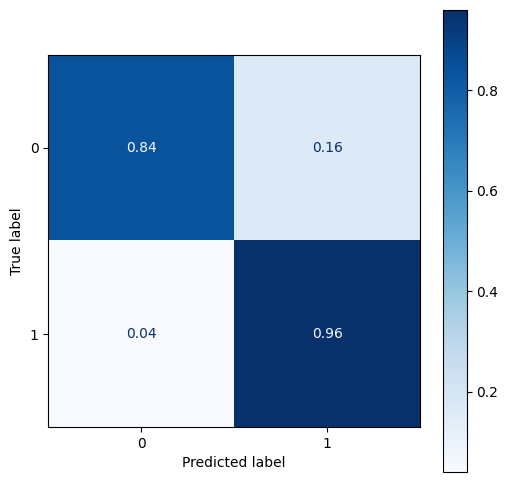

----------------------------------------
RF: depth=3, estimators=5, fold_idx=0


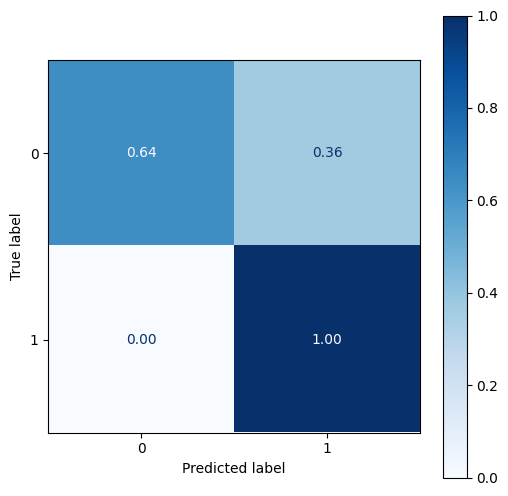

----------------------------------------
RF: depth=3, estimators=5, fold_idx=1


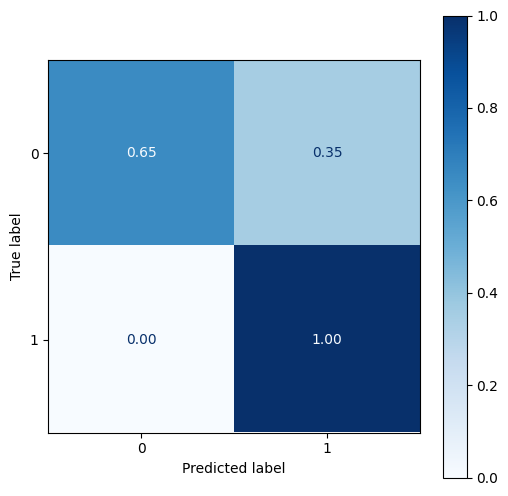

----------------------------------------
RF: depth=3, estimators=5, fold_idx=2


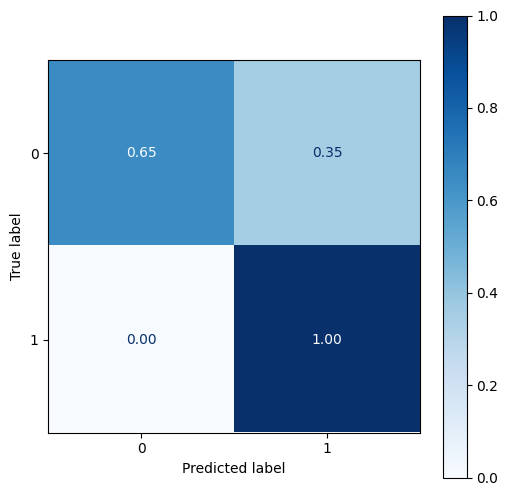

----------------------------------------
RF: depth=3, estimators=5, fold_idx=3


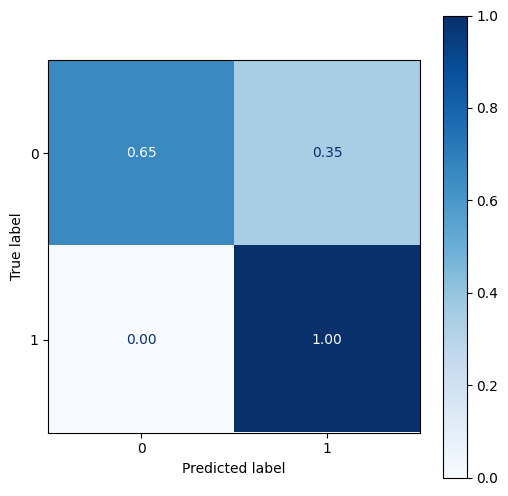

----------------------------------------
RF: depth=3, estimators=5, fold_idx=4


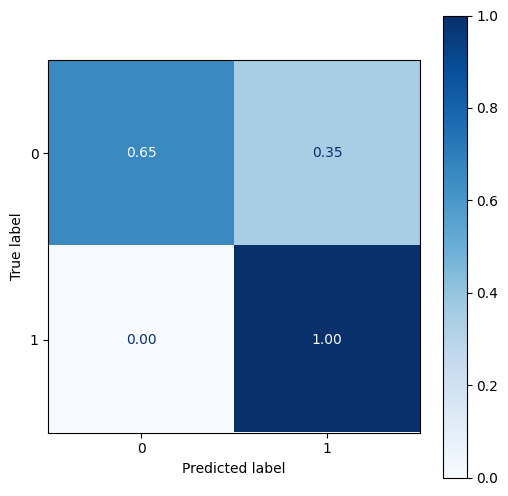

----------------------------------------
RF: depth=6, estimators=5, fold_idx=0


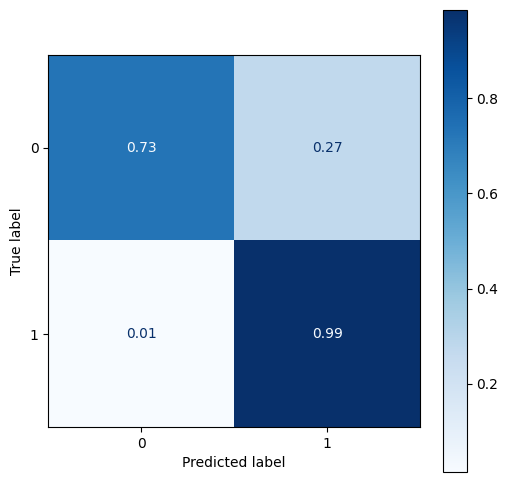

----------------------------------------
RF: depth=6, estimators=5, fold_idx=1


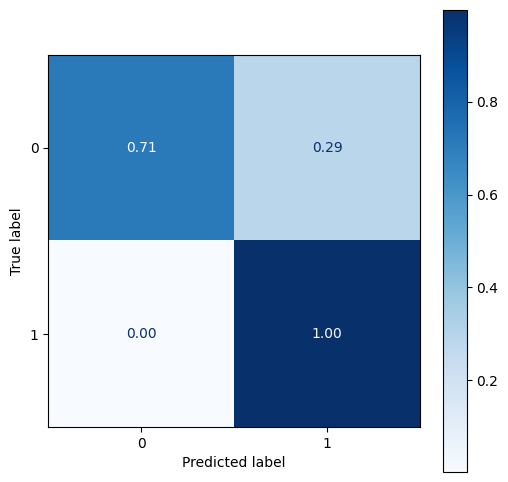

----------------------------------------
RF: depth=6, estimators=5, fold_idx=2


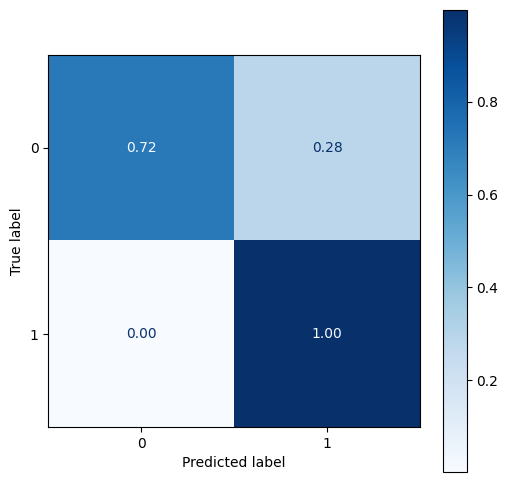

----------------------------------------
RF: depth=6, estimators=5, fold_idx=3


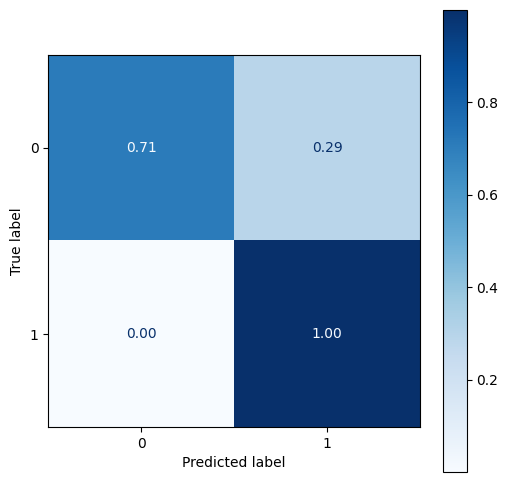

----------------------------------------
RF: depth=6, estimators=5, fold_idx=4


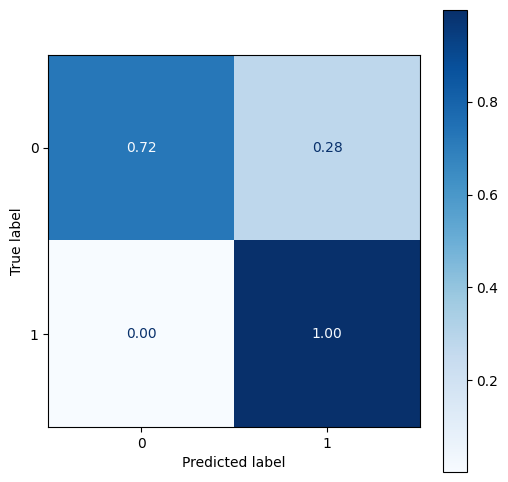

----------------------------------------
RF: depth=9, estimators=5, fold_idx=0


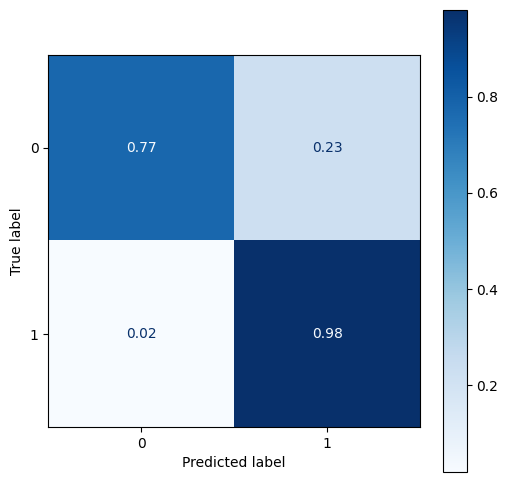

----------------------------------------
RF: depth=9, estimators=5, fold_idx=1


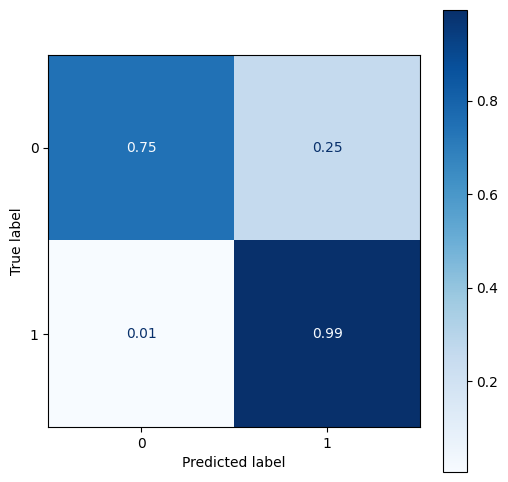

----------------------------------------
RF: depth=9, estimators=5, fold_idx=2


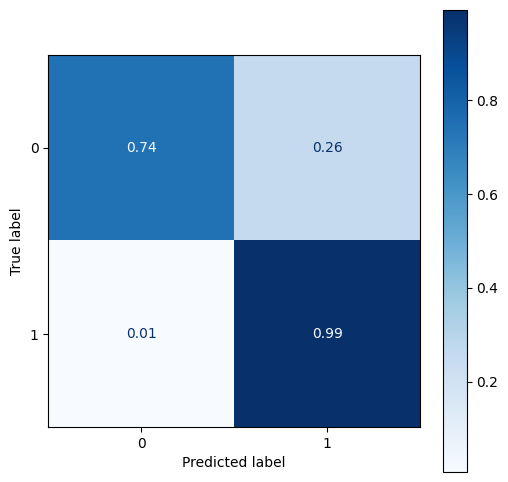

----------------------------------------
RF: depth=9, estimators=5, fold_idx=3


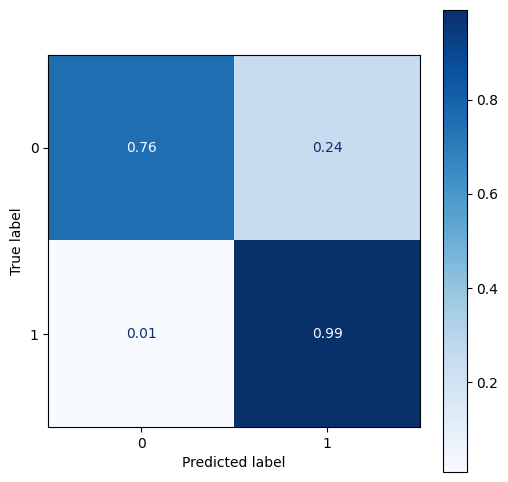

----------------------------------------
RF: depth=9, estimators=5, fold_idx=4


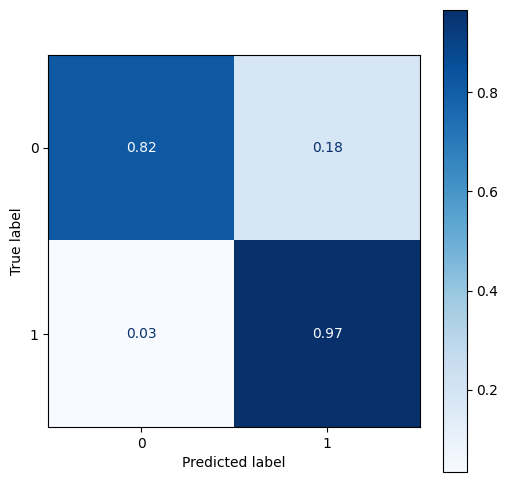

----------------------------------------
BNN [32, 16, 2] , fold_idx=0
Epoch 1/15
867/906 [===========================>..] - ETA: 0s - loss: 1.0212 - accuracy: 0.6939
Epoch 1: val_accuracy improved from -inf to 0.48440, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold0.h5
906/906 [==============================] - 1s 934us/step - loss: 1.0141 - accuracy: 0.6978 - val_loss: 1.0845 - val_accuracy: 0.4844
Epoch 2/15
182/906 [=====>........................] - ETA: 0s - loss: 0.8382 - accuracy: 0.8005

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


883/906 [============================>.] - ETA: 0s - loss: 0.8245 - accuracy: 0.8107
Epoch 2: val_accuracy improved from 0.48440 to 0.82738, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold0.h5
906/906 [==============================] - 1s 868us/step - loss: 0.8246 - accuracy: 0.8105 - val_loss: 0.8111 - val_accuracy: 0.8274
Epoch 3/15
891/906 [============================>.] - ETA: 0s - loss: 0.7859 - accuracy: 0.8411
Epoch 3: val_accuracy improved from 0.82738 to 0.86460, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold0.h5
906/906 [==============================] - 1s 807us/step - loss: 0.7853 - accuracy: 0.8415 - val_loss: 0.7688 - val_accuracy: 0.8646
Epoch 4/15
859/906 [===========================>..] - ETA: 0s - loss: 0.7489 - accuracy: 0.8694
Epoch 4: val_accuracy improved from 0.86460 to 0.86638, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold0.h5
906/906 [=============

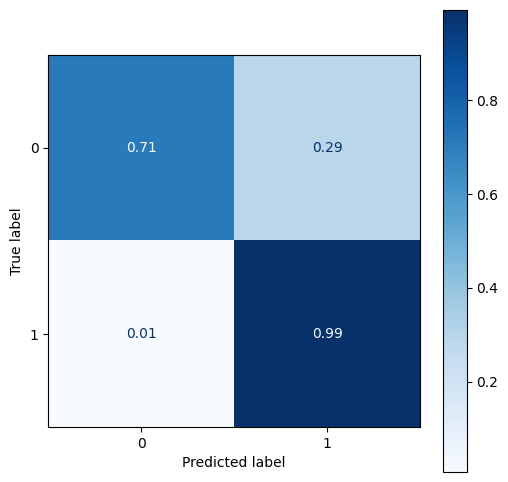

----------------------------------------
BNN [32, 16, 2] , fold_idx=1
Epoch 1/15
872/906 [===========================>..] - ETA: 0s - loss: 0.9051 - accuracy: 0.7918
Epoch 1: val_accuracy improved from -inf to 0.83297, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold1.h5
906/906 [==============================] - 1s 981us/step - loss: 0.9018 - accuracy: 0.7936 - val_loss: 0.8195 - val_accuracy: 0.8330
Epoch 2/15
196/906 [=====>........................] - ETA: 0s - loss: 0.8202 - accuracy: 0.8346

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


901/906 [============================>.] - ETA: 0s - loss: 0.7985 - accuracy: 0.8467
Epoch 2: val_accuracy improved from 0.83297 to 0.85358, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold1.h5
906/906 [==============================] - 1s 864us/step - loss: 0.7983 - accuracy: 0.8468 - val_loss: 0.8085 - val_accuracy: 0.8536
Epoch 3/15
884/906 [============================>.] - ETA: 0s - loss: 0.7537 - accuracy: 0.8712
Epoch 3: val_accuracy improved from 0.85358 to 0.88303, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold1.h5
906/906 [==============================] - 1s 874us/step - loss: 0.7537 - accuracy: 0.8712 - val_loss: 0.7640 - val_accuracy: 0.8830
Epoch 4/15
870/906 [===========================>..] - ETA: 0s - loss: 0.7389 - accuracy: 0.8798
Epoch 4: val_accuracy improved from 0.88303 to 0.88878, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold1.h5
906/906 [=============

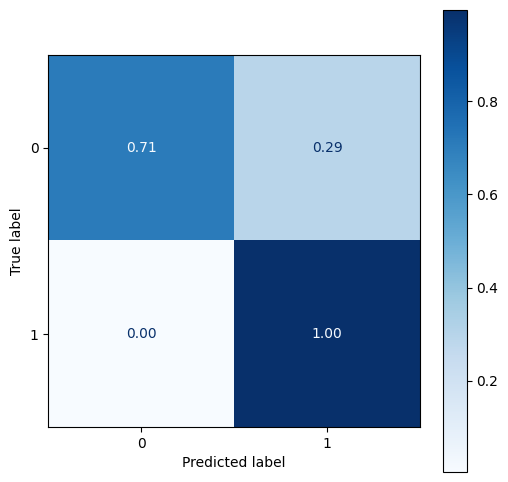

----------------------------------------
BNN [32, 16, 2] , fold_idx=2
Epoch 1/15
881/906 [============================>.] - ETA: 0s - loss: 0.9734 - accuracy: 0.7567
Epoch 1: val_accuracy improved from -inf to 0.81702, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold2.h5
906/906 [==============================] - 1s 911us/step - loss: 0.9703 - accuracy: 0.7583 - val_loss: 0.8859 - val_accuracy: 0.8170
Epoch 2/15
202/906 [=====>........................] - ETA: 0s - loss: 0.8647 - accuracy: 0.8122

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


856/906 [===========================>..] - ETA: 0s - loss: 0.8335 - accuracy: 0.8166
Epoch 2: val_accuracy improved from 0.81702 to 0.86301, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold2.h5
906/906 [==============================] - 1s 830us/step - loss: 0.8312 - accuracy: 0.8176 - val_loss: 0.7694 - val_accuracy: 0.8630
Epoch 3/15
847/906 [===========================>..] - ETA: 0s - loss: 0.7804 - accuracy: 0.8490
Epoch 3: val_accuracy improved from 0.86301 to 0.86514, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold2.h5
906/906 [==============================] - 1s 786us/step - loss: 0.7793 - accuracy: 0.8498 - val_loss: 0.7657 - val_accuracy: 0.8651
Epoch 4/15
854/906 [===========================>..] - ETA: 0s - loss: 0.7559 - accuracy: 0.8634
Epoch 4: val_accuracy improved from 0.86514 to 0.87927, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold2.h5
906/906 [=============

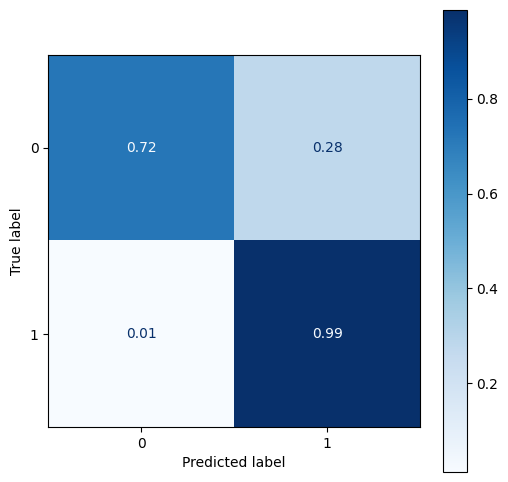

----------------------------------------
BNN [32, 16, 2] , fold_idx=3
Epoch 1/15
865/906 [===========================>..] - ETA: 0s - loss: 1.0920 - accuracy: 0.6604
Epoch 1: val_accuracy improved from -inf to 0.79257, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold3.h5
906/906 [==============================] - 1s 1ms/step - loss: 1.0817 - accuracy: 0.6659 - val_loss: 0.8625 - val_accuracy: 0.7926
Epoch 2/15
178/906 [====>.........................] - ETA: 0s - loss: 0.8616 - accuracy: 0.7742

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


865/906 [===========================>..] - ETA: 0s - loss: 0.8151 - accuracy: 0.8078
Epoch 2: val_accuracy improved from 0.79257 to 0.86347, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold3.h5
906/906 [==============================] - 1s 945us/step - loss: 0.8134 - accuracy: 0.8091 - val_loss: 0.7522 - val_accuracy: 0.8635
Epoch 3/15
884/906 [============================>.] - ETA: 0s - loss: 0.7683 - accuracy: 0.8481
Epoch 3: val_accuracy improved from 0.86347 to 0.87069, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold3.h5
906/906 [==============================] - 1s 817us/step - loss: 0.7676 - accuracy: 0.8487 - val_loss: 0.7432 - val_accuracy: 0.8707
Epoch 4/15
895/906 [============================>.] - ETA: 0s - loss: 0.7535 - accuracy: 0.8611
Epoch 4: val_accuracy improved from 0.87069 to 0.87690, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold3.h5
906/906 [=============

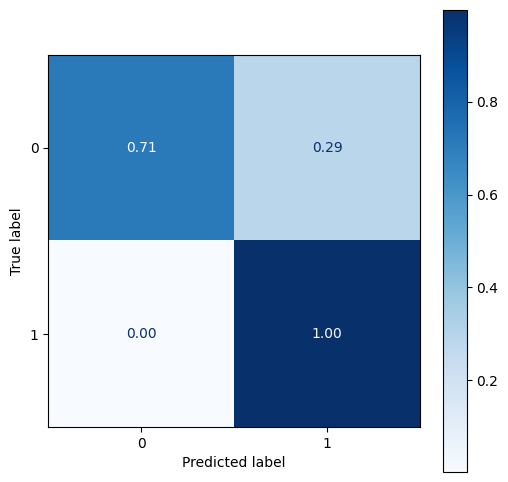

----------------------------------------
BNN [32, 16, 2] , fold_idx=4
Epoch 1/15
847/906 [===========================>..] - ETA: 0s - loss: 0.9623 - accuracy: 0.6841
Epoch 1: val_accuracy improved from -inf to 0.82758, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold4.h5
906/906 [==============================] - 1s 944us/step - loss: 0.9531 - accuracy: 0.6910 - val_loss: 0.7984 - val_accuracy: 0.8276
Epoch 2/15
197/906 [=====>........................] - ETA: 0s - loss: 0.8048 - accuracy: 0.8008

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


885/906 [============================>.] - ETA: 0s - loss: 0.7859 - accuracy: 0.8246
Epoch 2: val_accuracy improved from 0.82758 to 0.83949, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold4.h5
906/906 [==============================] - 1s 807us/step - loss: 0.7853 - accuracy: 0.8253 - val_loss: 0.7616 - val_accuracy: 0.8395
Epoch 3/15
899/906 [============================>.] - ETA: 0s - loss: 0.7609 - accuracy: 0.8480
Epoch 3: val_accuracy improved from 0.83949 to 0.86650, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold4.h5
906/906 [==============================] - 1s 855us/step - loss: 0.7609 - accuracy: 0.8480 - val_loss: 0.7400 - val_accuracy: 0.8665
Epoch 4/15
902/906 [============================>.] - ETA: 0s - loss: 0.7495 - accuracy: 0.8586
Epoch 4: val_accuracy improved from 0.86650 to 0.87636, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__32_16_2__fold4.h5
906/906 [=============

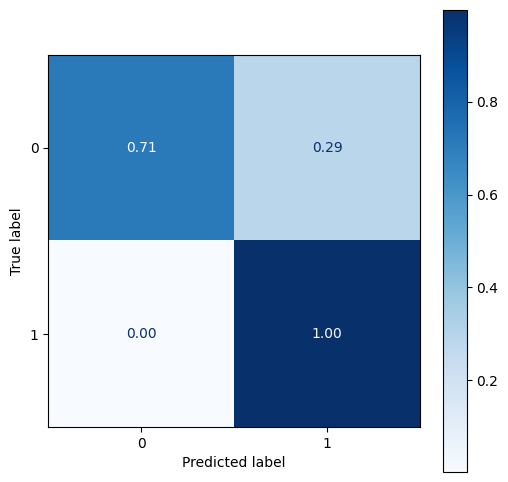

----------------------------------------
BNN [64, 32, 2] , fold_idx=0
Epoch 1/15
888/906 [============================>.] - ETA: 0s - loss: 0.9313 - accuracy: 0.7774
Epoch 1: val_accuracy improved from -inf to 0.84512, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold0.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.9283 - accuracy: 0.7790 - val_loss: 0.8312 - val_accuracy: 0.8451
Epoch 2/15
184/906 [=====>........................] - ETA: 0s - loss: 0.7793 - accuracy: 0.8572

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


875/906 [===========================>..] - ETA: 0s - loss: 0.7498 - accuracy: 0.8722
Epoch 2: val_accuracy improved from 0.84512 to 0.87488, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold0.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7492 - accuracy: 0.8723 - val_loss: 0.7370 - val_accuracy: 0.8749
Epoch 3/15
893/906 [============================>.] - ETA: 0s - loss: 0.7303 - accuracy: 0.8788
Epoch 3: val_accuracy improved from 0.87488 to 0.88532, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold0.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7304 - accuracy: 0.8787 - val_loss: 0.7285 - val_accuracy: 0.8853
Epoch 4/15
864/906 [===========================>..] - ETA: 0s - loss: 0.7186 - accuracy: 0.8867
Epoch 4: val_accuracy did not improve from 0.88532
906/906 [==============================] - 1s 947us/step - loss: 0.7187 - accuracy: 0.8867 - val_loss: 0.7380 - val_accu

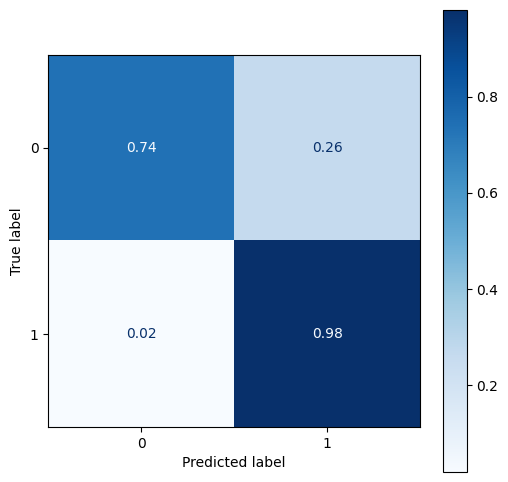

----------------------------------------
BNN [64, 32, 2] , fold_idx=1
Epoch 1/15
888/906 [============================>.] - ETA: 0s - loss: 0.9161 - accuracy: 0.7795
Epoch 1: val_accuracy improved from -inf to 0.85043, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold1.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.9137 - accuracy: 0.7808 - val_loss: 0.7795 - val_accuracy: 0.8504
Epoch 2/15
169/906 [====>.........................] - ETA: 0s - loss: 0.7764 - accuracy: 0.8562

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


860/906 [===========================>..] - ETA: 0s - loss: 0.7536 - accuracy: 0.8689
Epoch 2: val_accuracy improved from 0.85043 to 0.87360, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold1.h5
906/906 [==============================] - 1s 951us/step - loss: 0.7532 - accuracy: 0.8689 - val_loss: 0.7416 - val_accuracy: 0.8736
Epoch 3/15
856/906 [===========================>..] - ETA: 0s - loss: 0.7305 - accuracy: 0.8821
Epoch 3: val_accuracy improved from 0.87360 to 0.89017, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold1.h5
906/906 [==============================] - 1s 901us/step - loss: 0.7307 - accuracy: 0.8820 - val_loss: 0.7208 - val_accuracy: 0.8902
Epoch 4/15
866/906 [===========================>..] - ETA: 0s - loss: 0.7237 - accuracy: 0.8861
Epoch 4: val_accuracy improved from 0.89017 to 0.89145, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold1.h5
906/906 [=============

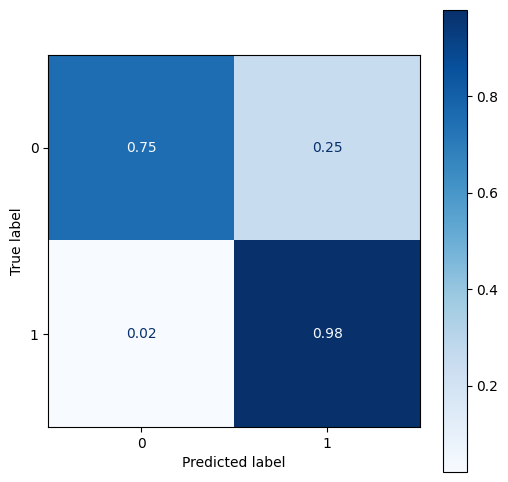

----------------------------------------
BNN [64, 32, 2] , fold_idx=2
Epoch 1/15
898/906 [============================>.] - ETA: 0s - loss: 0.8890 - accuracy: 0.7752
Epoch 1: val_accuracy improved from -inf to 0.82579, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold2.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.8883 - accuracy: 0.7756 - val_loss: 0.7864 - val_accuracy: 0.8258
Epoch 2/15
194/906 [=====>........................] - ETA: 0s - loss: 0.7926 - accuracy: 0.8245

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


902/906 [============================>.] - ETA: 0s - loss: 0.7684 - accuracy: 0.8468
Epoch 2: val_accuracy improved from 0.82579 to 0.86697, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold2.h5
906/906 [==============================] - 1s 925us/step - loss: 0.7681 - accuracy: 0.8470 - val_loss: 0.7605 - val_accuracy: 0.8670
Epoch 3/15
881/906 [============================>.] - ETA: 0s - loss: 0.7382 - accuracy: 0.8787
Epoch 3: val_accuracy improved from 0.86697 to 0.88819, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold2.h5
906/906 [==============================] - 1s 941us/step - loss: 0.7380 - accuracy: 0.8789 - val_loss: 0.7208 - val_accuracy: 0.8882
Epoch 4/15
901/906 [============================>.] - ETA: 0s - loss: 0.7278 - accuracy: 0.8847
Epoch 4: val_accuracy did not improve from 0.88819
906/906 [==============================] - 1s 953us/step - loss: 0.7278 - accuracy: 0.8847 - val_loss: 0.7369 - val_

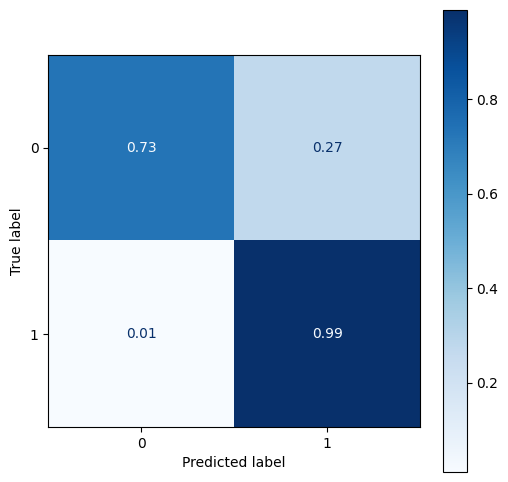

----------------------------------------
BNN [64, 32, 2] , fold_idx=3
Epoch 1/15
870/906 [===========================>..] - ETA: 0s - loss: 0.9010 - accuracy: 0.7805
Epoch 1: val_accuracy improved from -inf to 0.85455, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold3.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.8962 - accuracy: 0.7833 - val_loss: 0.7792 - val_accuracy: 0.8545
Epoch 2/15
178/906 [====>.........................] - ETA: 0s - loss: 0.7603 - accuracy: 0.8628

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


892/906 [============================>.] - ETA: 0s - loss: 0.7500 - accuracy: 0.8681
Epoch 2: val_accuracy improved from 0.85455 to 0.88594, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold3.h5
906/906 [==============================] - 1s 924us/step - loss: 0.7499 - accuracy: 0.8682 - val_loss: 0.7186 - val_accuracy: 0.8859
Epoch 3/15
894/906 [============================>.] - ETA: 0s - loss: 0.7267 - accuracy: 0.8812
Epoch 3: val_accuracy improved from 0.88594 to 0.88905, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold3.h5
906/906 [==============================] - 1s 991us/step - loss: 0.7267 - accuracy: 0.8812 - val_loss: 0.7161 - val_accuracy: 0.8890
Epoch 4/15
901/906 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.8838
Epoch 4: val_accuracy did not improve from 0.88905
906/906 [==============================] - 1s 980us/step - loss: 0.7215 - accuracy: 0.8838 - val_loss: 0.7125 - val_

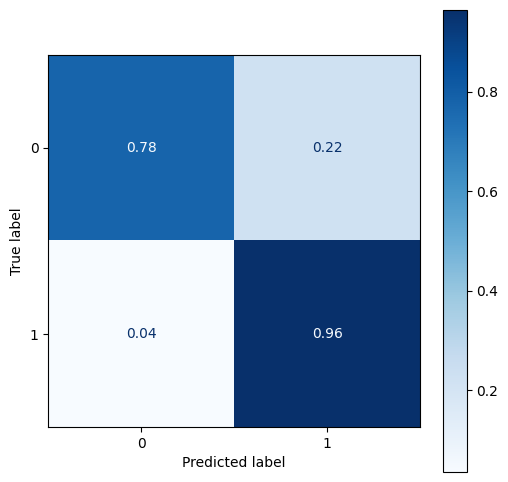

----------------------------------------
BNN [64, 32, 2] , fold_idx=4
Epoch 1/15
856/906 [===========================>..] - ETA: 0s - loss: 0.8735 - accuracy: 0.8020
Epoch 1: val_accuracy improved from -inf to 0.60175, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold4.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.8676 - accuracy: 0.8051 - val_loss: 1.2531 - val_accuracy: 0.6018
Epoch 2/15
171/906 [====>.........................] - ETA: 0s - loss: 0.7582 - accuracy: 0.8654

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


869/906 [===========================>..] - ETA: 0s - loss: 0.7499 - accuracy: 0.8717
Epoch 2: val_accuracy improved from 0.60175 to 0.88990, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold4.h5
906/906 [==============================] - 1s 996us/step - loss: 0.7490 - accuracy: 0.8722 - val_loss: 0.7157 - val_accuracy: 0.8899
Epoch 3/15
877/906 [============================>.] - ETA: 0s - loss: 0.7253 - accuracy: 0.8855
Epoch 3: val_accuracy did not improve from 0.88990
906/906 [==============================] - 1s 934us/step - loss: 0.7254 - accuracy: 0.8855 - val_loss: 0.7238 - val_accuracy: 0.8861
Epoch 4/15
876/906 [============================>.] - ETA: 0s - loss: 0.7198 - accuracy: 0.8876
Epoch 4: val_accuracy improved from 0.88990 to 0.89130, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__64_32_2__fold4.h5
906/906 [==============================] - 1s 938us/step - loss: 0.7194 - accuracy: 0.8878 - val_loss: 0.7139 - val_

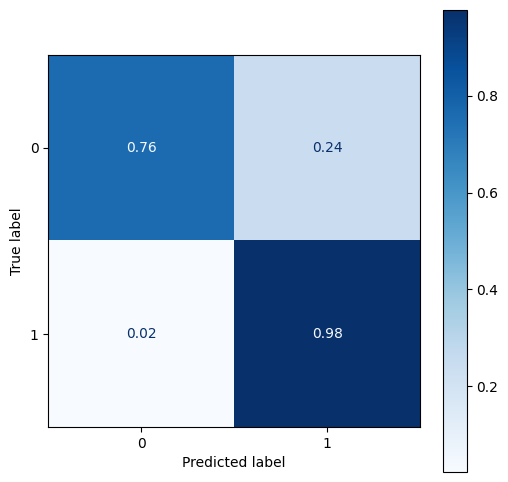

----------------------------------------
BNN [128, 64, 2] , fold_idx=0
Epoch 1/15
878/906 [============================>.] - ETA: 0s - loss: 0.8395 - accuracy: 0.8169
Epoch 1: val_accuracy improved from -inf to 0.86312, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.8365 - accuracy: 0.8186 - val_loss: 0.7560 - val_accuracy: 0.8631
Epoch 2/15
110/906 [==>...........................] - ETA: 1s - loss: 0.7325 - accuracy: 0.8773

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


877/906 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.8800
Epoch 2: val_accuracy improved from 0.86312 to 0.88288, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7298 - accuracy: 0.8801 - val_loss: 0.7321 - val_accuracy: 0.8829
Epoch 3/15
864/906 [===========================>..] - ETA: 0s - loss: 0.7200 - accuracy: 0.8871
Epoch 3: val_accuracy improved from 0.88288 to 0.88625, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7203 - accuracy: 0.8871 - val_loss: 0.7251 - val_accuracy: 0.8863
Epoch 4/15
902/906 [============================>.] - ETA: 0s - loss: 0.7142 - accuracy: 0.8915
Epoch 4: val_accuracy improved from 0.88625 to 0.88998, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold0.h5
906/906 [==============

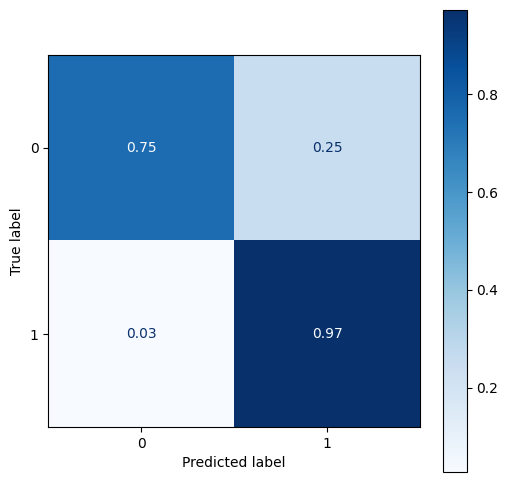

----------------------------------------
BNN [128, 64, 2] , fold_idx=1
Epoch 1/15
867/906 [===========================>..] - ETA: 0s - loss: 0.8631 - accuracy: 0.8055
Epoch 1: val_accuracy improved from -inf to 0.86413, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold1.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.8584 - accuracy: 0.8079 - val_loss: 0.7528 - val_accuracy: 0.8641
Epoch 2/15
121/906 [===>..........................] - ETA: 0s - loss: 0.7411 - accuracy: 0.8722

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


878/906 [============================>.] - ETA: 0s - loss: 0.7307 - accuracy: 0.8802
Epoch 2: val_accuracy improved from 0.86413 to 0.88707, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold1.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7303 - accuracy: 0.8805 - val_loss: 0.7185 - val_accuracy: 0.8871
Epoch 3/15
899/906 [============================>.] - ETA: 0s - loss: 0.7189 - accuracy: 0.8886
Epoch 3: val_accuracy improved from 0.88707 to 0.89242, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold1.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7188 - accuracy: 0.8886 - val_loss: 0.7124 - val_accuracy: 0.8924
Epoch 4/15
870/906 [===========================>..] - ETA: 0s - loss: 0.7142 - accuracy: 0.8912
Epoch 4: val_accuracy improved from 0.89242 to 0.89359, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold1.h5
906/906 [==============

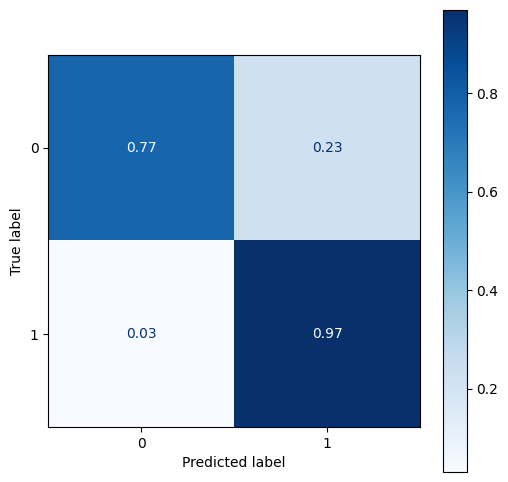

----------------------------------------
BNN [128, 64, 2] , fold_idx=2
Epoch 1/15
873/906 [===========================>..] - ETA: 0s - loss: 0.8250 - accuracy: 0.8249
Epoch 1: val_accuracy improved from -inf to 0.86103, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.8230 - accuracy: 0.8261 - val_loss: 0.7602 - val_accuracy: 0.8610
Epoch 2/15
133/906 [===>..........................] - ETA: 0s - loss: 0.7514 - accuracy: 0.8657

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


883/906 [============================>.] - ETA: 0s - loss: 0.7440 - accuracy: 0.8741
Epoch 2: val_accuracy improved from 0.86103 to 0.88858, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7436 - accuracy: 0.8744 - val_loss: 0.7266 - val_accuracy: 0.8886
Epoch 3/15
895/906 [============================>.] - ETA: 0s - loss: 0.7232 - accuracy: 0.8866
Epoch 3: val_accuracy improved from 0.88858 to 0.88994, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7231 - accuracy: 0.8866 - val_loss: 0.7184 - val_accuracy: 0.8899
Epoch 4/15
868/906 [===========================>..] - ETA: 0s - loss: 0.7176 - accuracy: 0.8896
Epoch 4: val_accuracy improved from 0.88994 to 0.89118, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold2.h5
906/906 [==============

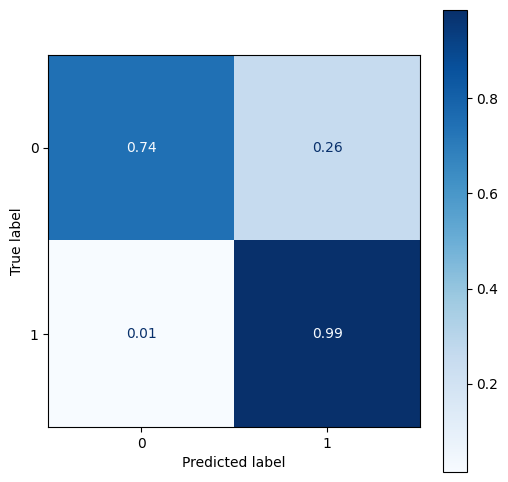

----------------------------------------
BNN [128, 64, 2] , fold_idx=3
Epoch 1/15
885/906 [============================>.] - ETA: 0s - loss: 0.8178 - accuracy: 0.8380
Epoch 1: val_accuracy improved from -inf to 0.64328, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold3.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.8161 - accuracy: 0.8390 - val_loss: 1.1231 - val_accuracy: 0.6433
Epoch 2/15
116/906 [==>...........................] - ETA: 1s - loss: 0.7316 - accuracy: 0.8833

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/906 [============================>.] - ETA: 0s - loss: 0.7294 - accuracy: 0.8840
Epoch 2: val_accuracy improved from 0.64328 to 0.89064, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold3.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7293 - accuracy: 0.8840 - val_loss: 0.7253 - val_accuracy: 0.8906
Epoch 3/15
903/906 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.8892
Epoch 3: val_accuracy improved from 0.89064 to 0.89456, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold3.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7196 - accuracy: 0.8893 - val_loss: 0.7098 - val_accuracy: 0.8946
Epoch 4/15
875/906 [===========================>..] - ETA: 0s - loss: 0.7143 - accuracy: 0.8918
Epoch 4: val_accuracy improved from 0.89456 to 0.89731, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold3.h5
906/906 [==============

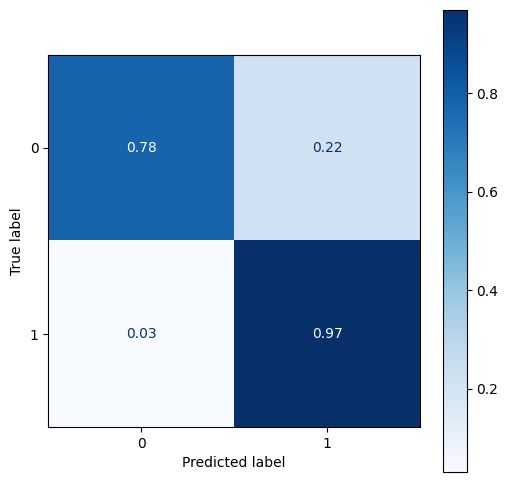

----------------------------------------
BNN [128, 64, 2] , fold_idx=4
Epoch 1/15
871/906 [===========================>..] - ETA: 0s - loss: 0.9179 - accuracy: 0.7857
Epoch 1: val_accuracy improved from -inf to 0.86518, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 2s 1ms/step - loss: 0.9121 - accuracy: 0.7887 - val_loss: 0.7596 - val_accuracy: 0.8652
Epoch 2/15
109/906 [==>...........................] - ETA: 1s - loss: 0.7651 - accuracy: 0.8651

/home/rizky/cs5584/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


873/906 [===========================>..] - ETA: 0s - loss: 0.7514 - accuracy: 0.8714
Epoch 2: val_accuracy improved from 0.86518 to 0.88292, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7513 - accuracy: 0.8715 - val_loss: 0.7273 - val_accuracy: 0.8829
Epoch 3/15
882/906 [============================>.] - ETA: 0s - loss: 0.7283 - accuracy: 0.8836
Epoch 3: val_accuracy improved from 0.88292 to 0.88559, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============================] - 1s 1ms/step - loss: 0.7285 - accuracy: 0.8835 - val_loss: 0.7260 - val_accuracy: 0.8856
Epoch 4/15
862/906 [===========================>..] - ETA: 0s - loss: 0.7190 - accuracy: 0.8882
Epoch 4: val_accuracy improved from 0.88559 to 0.89305, saving model to models/simple_feature_bnn__sec_StratifiedShuffleSplit__128_64_2__fold4.h5
906/906 [==============

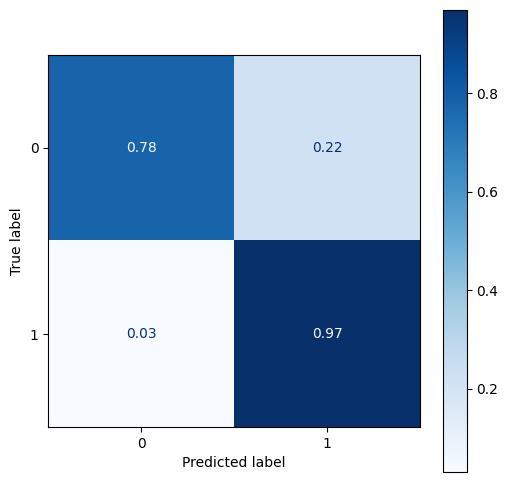

----------------------------------------


In [23]:
accuracy_store_sec = {}
precision_store_sec = {}
recall_store_sec = {}
tpr_store_sec = {}
fpr_store_sec = {}
fnr_store_sec = {}
f1_store_sec = {}
roc_auc_store_sec = {}

########################################

skf = StratifiedShuffleSplit(n_splits=num_folds, random_state=0)

for depth in depths_range:    
    label = 'dt__depth_%d' % (depth)
    accuracy_store_sec[label] = np.zeros(num_folds)
    precision_store_sec[label] = np.zeros(num_folds)
    recall_store_sec[label] = np.zeros(num_folds)
    tpr_store_sec[label] = np.zeros(num_folds)
    fpr_store_sec[label] = np.zeros(num_folds)
    fnr_store_sec[label] = np.zeros(num_folds)
    f1_store_sec[label] = np.zeros(num_folds)
    roc_auc_store_sec[label] = np.zeros(num_folds)
    
    fold_idx = 0
    for train_index, test_index in skf.split(X, Y):
        print('DT: depth=%d, fold_idx=%d' % (depth, fold_idx))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y__2_classes[train_index], Y__2_classes[test_index]
                        
        dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=0)
        dt = dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        y_score = dt.predict_proba(X_test)
        if depth==3:
            tree.plot_tree(dt, proportion=True)
            plt.show()

        a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(dt, X_test, y_test, y_pred, y_score)
        accuracy_store_sec[label][fold_idx] = a
        precision_store_sec[label][fold_idx] = p
        recall_store_sec[label][fold_idx] = r
        tpr_store_sec[label][fold_idx] = tpr
        fpr_store_sec[label][fold_idx] = fpr
        fnr_store_sec[label][fold_idx] = fnr
        f1_store_sec[label][fold_idx] = f1
        roc_auc_store_sec[label][fold_idx] = roc_auc

        fold_idx += 1

        print('-'*40)
    
    print('='*80)

########################################################################################

for depth in depths_range:
    for estimators in estimators_range:
        label = 'rf__depth_%d__estimators_%d' % (depth, estimators)
        accuracy_store_sec[label] = np.zeros(num_folds)
        precision_store_sec[label] = np.zeros(num_folds)
        recall_store_sec[label] = np.zeros(num_folds)
        tpr_store_sec[label] = np.zeros(num_folds)
        fpr_store_sec[label] = np.zeros(num_folds)
        fnr_store_sec[label] = np.zeros(num_folds)
        f1_store_sec[label] = np.zeros(num_folds)
        roc_auc_store_sec[label] = np.zeros(num_folds)

        fold_idx = 0
        for train_index, test_index in skf.split(X, Y):
            print('RF: depth=%d, estimators=%d, fold_idx=%d' % (depth, estimators, fold_idx))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y__2_classes[train_index], Y__2_classes[test_index]

            rf = RandomForestClassifier(criterion='entropy', max_depth=depth, n_estimators=estimators, random_state=0)
            rf = rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_score = rf.predict_proba(X_test)

            a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(rf, X_test, y_test, y_pred, y_score)
            accuracy_store_sec[label][fold_idx] = a
            precision_store_sec[label][fold_idx] = p
            recall_store_sec[label][fold_idx] = r
            tpr_store_sec[label][fold_idx] = tpr
            fpr_store_sec[label][fold_idx] = fpr
            fnr_store_sec[label][fold_idx] = fnr
            f1_store_sec[label][fold_idx] = f1
            roc_auc_store_sec[label][fold_idx] = roc_auc
        
            fold_idx += 1

            print('-'*40)
            
        print('='*40)

    print('='*80)

########################################################################################

for neurons in bnn_models:
    label = 'bnn__%s' % ('_'.join(map(str, neurons)))
    accuracy_store_sec[label] = np.zeros(num_folds)
    precision_store_sec[label] = np.zeros(num_folds)
    recall_store_sec[label] = np.zeros(num_folds)
    tpr_store_sec[label] = np.zeros(num_folds)
    fpr_store_sec[label] = np.zeros(num_folds)
    fnr_store_sec[label] = np.zeros(num_folds)
    f1_store_sec[label] = np.zeros(num_folds)
    roc_auc_store_sec[label] = np.zeros(num_folds)
    
    fold_idx = 0
    for train_index, test_index in skf.split(X, Y):
        print('BNN', neurons ,', fold_idx=%d' % (fold_idx))
        X_train, X_test = X_bin[train_index], X_bin[test_index]
        y_train, y_test = Y_cat__2_classes[train_index], Y_cat__2_classes[test_index]
                        
        model = build_bnn_model(neurons, X_bin.shape[1])   
        fname = 'simple_feature_bnn__sec_StratifiedShuffleSplit__%s__fold%d.h5' % ('_'.join(map(str, neurons)), fold_idx)
        
        model_checkpoint_callback = ModelCheckpoint(
            filepath='models/' + fname,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1)
        
        if not os.path.isfile('models/' + fname):
            train_history = model.fit(X_train, y_train, 
                              batch_size=batch_size, 
                              epochs=train_epochs,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[model_checkpoint_callback])
                    
            # Reload best weights
            model.load_weights('models/' + fname)
        else:
            # Reload stored weights
            print('Loading models/' + fname)
            model.load_weights('models/' + fname)

        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob,axis=1)
        y_score = y_prob[y_pred]
        
        a, p, r, tpr, fpr, fnr, f1, roc_auc = metrics_binary_dataset(model, X_test, y_test, y_pred, y_score, is_bnn=True)
        accuracy_store_sec[label][fold_idx] = a
        precision_store_sec[label][fold_idx] = p
        recall_store_sec[label][fold_idx] = r
        tpr_store_sec[label][fold_idx] = tpr
        fpr_store_sec[label][fold_idx] = fpr
        fnr_store_sec[label][fold_idx] = fnr
        f1_store_sec[label][fold_idx] = f1
        roc_auc_store_sec[label][fold_idx] = roc_auc
        
        fold_idx += 1
        
        print('-'*40)
    
    print('='*80)

In [24]:
for store,metric in zip([accuracy_store_sec, precision_store_sec, recall_store_sec,
                         fnr_store_sec, fpr_store_sec, f1_store_sec, roc_auc_store_sec],
                        ['Accuracy', 'Precision', 'Recall', 'FNR', 'FPR', 'F1-score', 'ROC-AUC']):
    print('[%s]' % metric)
    for key in store:
        print('%s: %.1f ± %.1f' % (key, 100*store[key].mean(), 100*store[key].std()))
    print()

[Accuracy]
dt__depth_3: 87.9 ± 0.2
dt__depth_6: 89.8 ± 0.3
dt__depth_9: 91.2 ± 0.4
rf__depth_3__estimators_5: 87.3 ± 0.2
rf__depth_6__estimators_5: 89.5 ± 0.2
rf__depth_9__estimators_5: 90.6 ± 0.3
bnn__32_16_2: 89.2 ± 0.2
bnn__64_32_2: 89.6 ± 0.2
bnn__128_64_2: 89.8 ± 0.3

[Precision]
dt__depth_3: 85.1 ± 0.2
dt__depth_6: 87.4 ± 1.2
dt__depth_9: 91.6 ± 0.5
rf__depth_3__estimators_5: 83.4 ± 0.2
rf__depth_6__estimators_5: 86.2 ± 0.3
rf__depth_9__estimators_5: 88.2 ± 1.1
bnn__32_16_2: 86.0 ± 0.2
bnn__64_32_2: 87.5 ± 0.6
bnn__128_64_2: 88.1 ± 0.6

[Recall]
dt__depth_3: 98.2 ± 0.0
dt__depth_6: 98.2 ± 1.2
dt__depth_9: 94.8 ± 1.2
rf__depth_3__estimators_5: 100.0 ± 0.0
rf__depth_6__estimators_5: 99.5 ± 0.5
rf__depth_9__estimators_5: 98.4 ± 1.1
bnn__32_16_2: 99.4 ± 0.4
bnn__64_32_2: 97.8 ± 0.8
bnn__128_64_2: 97.3 ± 0.6

[FNR]
dt__depth_3: 1.8 ± 0.0
dt__depth_6: 1.8 ± 1.2
dt__depth_9: 5.2 ± 1.2
rf__depth_3__estimators_5: 0.0 ± 0.0
rf__depth_6__estimators_5: 0.5 ± 0.5
rf__depth_9__estimators_5: 1.

# Figure for Reports

In [25]:
df = pd.concat([train_df,test_df])

In [26]:
df['proto'] =  df['proto'].astype('category')
df['proto'] =  df['proto'].cat.codes

In [27]:
numeric_columns = [
    'dur',
    'sbytes', 'dbytes',
    'sttl', 'dttl',
    'sload', 'dload',
    'spkts', 'dpkts',
    'smean', 'dmean',
    'sinpkt', 'dinpkt',
    'tcprtt', 'synack', 'ackdat',
    'ct_src_ltm', 'ct_dst_ltm',
    'ct_dst_src_ltm'
]

categorical_columns = [
    'proto',

    'attack_cat'
]

In [28]:
df['attack_cat_binary'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Malicious')

Text(0.5, 1.0, 'Protocol Distribution')

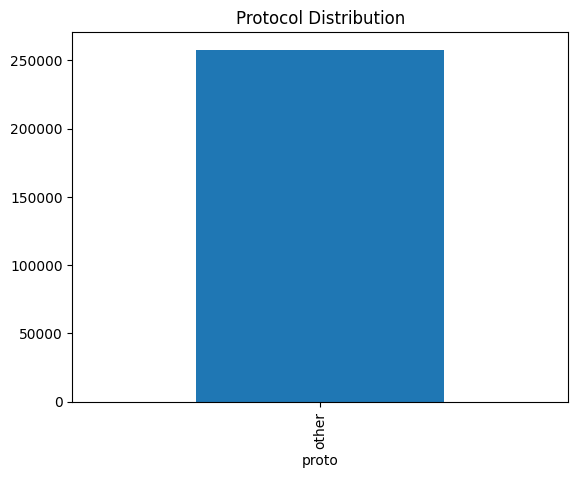

In [29]:
df['proto'].apply(lambda x: 'other' if x not in ['tcp','udp'] else x).value_counts().plot(kind='bar')
plt.title("Protocol Distribution")

Text(0.5, 1.0, 'Service Distribution')

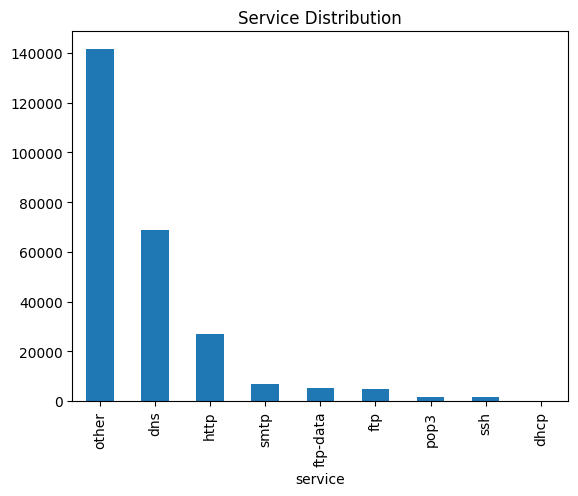

In [30]:
df['service'].apply(lambda x: 'other' if x not in ['dns','http','smtp','ftp-data','ftp','pop3','ssh','dhcp'] else x).value_counts().plot(kind='bar')
plt.title('Service Distribution')

Text(0.5, 1.0, 'Attack Distribution')

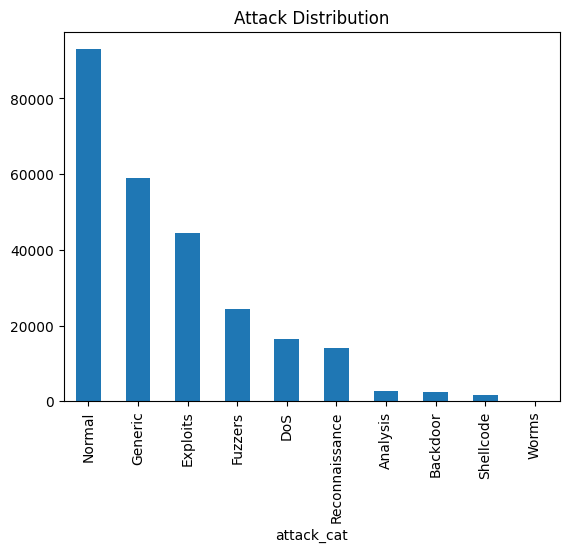

In [31]:
df['attack_cat'].value_counts().plot(kind='bar')
plt.title('Attack Distribution')